In [1]:
%load_ext autoreload
%autoreload 2
import json
import uproot
from XRootD import client
import xgboost as xgb
import os
import sys
sys.path.append("../../../analysisTools/")
from skimmerTools import Skimmer
import coffea
import coffea.util as util
import numpy as np
import awkward as ak
import time
import h5py

### Run Skimmers on skimmed ntuples with preselections, produce h5 files for BDT input

In [2]:
outdir = "./h5/"
os.system(f"mkdir -p {outdir}")

0

In [3]:
def write_h5(data,fname):
    with h5py.File(fname,'w') as f:
        for k in data.keys():
            arr = data[k].value
            if type(arr) == np.ma.core.MaskedArray:
                arr = arr.data
            f.create_dataset(k,data=arr)

In [4]:
suffix = "_TrueVertexForSignal"

In [5]:
cut_config = "./cut_configs/BDTskimmer_preselections.py"

In [6]:
sig_sample_json_dir = './sample_configs/'
jsons = [f for f in os.listdir(sig_sample_json_dir) if "json" in f]
signal_list = [ samp.split('.')[0] for samp in jsons if "signal_v9_miniAOD" in samp ]

print(signal_list)

['skimmed_signal_v9_miniAOD_2018_aEM']


In [7]:
bkg_sample_json_dir = './sample_configs/'
jsons = [f for f in os.listdir(bkg_sample_json_dir) if ".json" in f]
bkg_list = [ samp.split('.')[0] for samp in jsons if "bkg_2018_v7_miniAOD" in samp ]

print(bkg_list)

['skimmed_bkg_2018_v7_miniAOD']


In [8]:
for samp in signal_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{sig_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_signal_v9_miniAOD_2018_aEM


Output()

Output()

Completed in 2.14 min



In [9]:
for samp in bkg_list:
    print(f'Start analyzing: {samp}')
    
    test = Skimmer(f"{bkg_sample_json_dir}/{samp}.json", cut_config)
    
    t1 = time.time()
    out = test.process(execr='futures')
    t2 = time.time()

    write_h5(out[0],f"{outdir}/{samp}{suffix}.h5")
    
    print('Completed in {:.2f} min\n'.format((t2-t1)/60))
    del out, test

Start analyzing: skimmed_bkg_2018_v7_miniAOD


Output()

Output()

Completed in 1.58 min



# BDT

In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [11]:
# BDT variable combination (ROC-AUC, PR-AUC)

In [12]:
# BDT_15vars (0.9960, 0.9962)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
#             'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy', \
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
#             'delta_dxy_over_maxdxy', 'met_leadPt_ratio', 'log_delta_eta_over_delta_phi', 'sel_vtx_pt_e1_over_pt_e2'
#            ]

In [13]:
# BDT_9vars_comb1 (0.9955, 0.9957)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_projectedLxy', 'sel_vtx_prod_eta'
#]

In [14]:
# BDT_9vars_comb2 (0.9956, 0.9958)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta'
#]

# comparing with comb1, cos_collinear brings ever-so-slightly better AUCs

In [15]:
# BDT_8vars_comb3 (0.9950, 0.9951)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy',\
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta'
#]

# comparing with comb2, keep vxy_signif

In [16]:
# BDT_9vars_comb4 (0.9956, 0.9957)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'met_leadPt_ratio'
#]

# comparing with com2, met_leadPt_ratio is ever-so-slightly less performing than prod_eta

In [17]:
# BDT_9vars_comb5 (0.9957, 0.9958)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'log_delta_eta_over_delta_phi'
#]

# slightly better with log_dEta_over_dPhi than met_leadPt_ratio

In [18]:
# BDT_9vars_comb6 (0.9956, 0.9958)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_projectedLxy', 'log_delta_eta_over_delta_phi'
#]

# slightly better with cos angle than projectedlxy

In [19]:
# BDT_8vars_comb7 (0.9954, 0.9956)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy_signif',\
#             'sel_vtx_projectedLxy', 'log_delta_eta_over_delta_phi'
#]

# compare with comb6, definitely keep lxy

In [20]:
# BDT_9vars_comb8 (0.9955, 0.9957)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'sel_vtx_pt_over_m'
#]

In [21]:
# BDT_9vars_comb9 (0.9954, 0.9956)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'delta_dxy_over_maxdxy'
#]

In [22]:
# BDT_9vars_comb10 (0.9956, 0.9958)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'sel_vtx_pt_e1_over_pt_e2'
#]

In [110]:
# BDT_10vars_comb11 (0.9958, 0.9959)
variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'met_leadPt_ratio'
]

In [111]:
# BDT_10vars_comb12 (0.9957, 0.9959)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'log_delta_eta_over_delta_phi'
#]

In [112]:
# BDT_10vars_comb13 (0.9959, 0.9960)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'met_leadPt_ratio', 'log_delta_eta_over_delta_phi'
#]

In [113]:
# BDT_10vars_comb14 (0.9958, 0.9960)
#variables = ['sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_e1_over_pt_e2'
#]


In [114]:
# BDT_comb15
#variables = ['sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
#             'sel_vtx_minDxy','vxy','vxy_signif','sel_vtx_projectedLxy', \
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta', 'sel_vtx_pt_over_m', \
#             'delta_dxy_over_maxdxy', 'met_leadPt_ratio',
#            ]

In [115]:
# BDT_comb16
#variables = ['sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR',\
#             'sel_vtx_minDxy','vxy','vxy_signif', \
#             'sel_vtx_cos_collinear', 'sel_vtx_prod_eta',\
#             'delta_dxy_over_maxdxy', 'met_leadPt_ratio',
#            ]

In [116]:
# BDT_10vars_comb17
#variables = ['sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy','vxy','vxy_signif',\
#             'sel_vtx_cos_collinear', 'sel_vtx_projectedLxy', 'sel_vtx_prod_eta', 'met_leadPt_ratio'
#]

In [117]:
h5_dir = "./h5/"
sig_suffix = "_TrueVertexForSignal"

sig_files = [f for f in os.listdir(h5_dir) if sig_suffix in f and 'sig' in f]

sig_data = []

sig_data_train = []
sig_data_test = []
sig_point_train = {'m1':[], 'delta':[], 'ctau':[]}
sig_point_test = {'m1':[], 'delta':[], 'ctau':[]}

sig_xsec_norm = []

sig_xsec_norm_train = []
sig_xsec_norm_test = []
sig_point_test = {'m1':[], 'delta':[], 'ctau':[]}

sig_point = {'m1':[], 'delta':[], 'ctau':[]}

m1s = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for sf in sig_files:
    with h5py.File(f'{h5_dir}/{sf}',"r") as fin:
        entries = len(fin['wgt'])
        
        match = fin["sel_vtx_match"][()]
        mask = match==2

        entries_genMatched = sum(mask)
        print(f'Signal events {entries} -> {entries_genMatched} after gen matching (raw counts)\n')
        
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
        sig_xsec_norm.append(fin['wgt_norm'][()][mask])
        
        sig_point['m1'].append(fin['m1'][()][mask])
        sig_point['delta'].append(fin['delta'][()][mask])
        sig_point['ctau'].append(fin['ctau'][()][mask])

        # for loop for each signal point to get the sig_data_test and sig_data_train
        for m1 in m1s:
            for delta in deltas:
                for ctau in ctaus:
                    mask_sig_point = (fin['m1'][()][mask] == m1) & (fin['delta'][()][mask] == delta) & (fin['ctau'][()][mask] == ctau)
                    idx_train = int(0.8*len(fin['m1'][()][mask][mask_sig_point]))
                    #print(fin['m1'][()][mask][mask_sig_point][:idx_train])
                    sig_data_train.append(np.concatenate([fin[v][()][mask][mask_sig_point][:idx_train].reshape(-1,1) for v in variables],axis=1))
                    sig_data_test.append(np.concatenate([fin[v][()][mask][mask_sig_point][idx_train:].reshape(-1,1) for v in variables],axis=1))

                    sig_point_train['m1'].append(fin['m1'][()][mask][mask_sig_point][:idx_train])
                    sig_point_train['delta'].append(fin['delta'][()][mask][mask_sig_point][:idx_train])
                    sig_point_train['ctau'].append(fin['ctau'][()][mask][mask_sig_point][:idx_train])

                    sig_point_test['m1'].append(fin['m1'][()][mask][mask_sig_point][idx_train:])
                    sig_point_test['delta'].append(fin['delta'][()][mask][mask_sig_point][idx_train:])
                    sig_point_test['ctau'].append(fin['ctau'][()][mask][mask_sig_point][idx_train:])

                    sig_xsec_norm_train.append(fin['wgt_norm'][()][mask][mask_sig_point][:idx_train])
                    sig_xsec_norm_test.append(fin['wgt_norm'][()][mask][mask_sig_point][idx_train:])
                    

sig_data_train = np.concatenate(sig_data_train, axis=0)
sig_data_test = np.concatenate(sig_data_test, axis=0)

sig_data = np.concatenate(sig_data,axis=0)
sig_xsec_norm = np.concatenate(sig_xsec_norm,axis=0)

sig_xsec_norm_train = np.concatenate(sig_xsec_norm_train, axis=0)
sig_xsec_norm_test = np.concatenate(sig_xsec_norm_test, axis=0)

sig_point_train['m1'] = np.concatenate(sig_point_train['m1'], axis=0)
sig_point_train['delta'] = np.concatenate(sig_point_train['delta'], axis=0)
sig_point_train['ctau'] = np.concatenate(sig_point_train['ctau'], axis=0)

sig_point_test['m1'] = np.concatenate(sig_point_test['m1'], axis=0)
sig_point_test['delta'] = np.concatenate(sig_point_test['delta'], axis=0)
sig_point_test['ctau'] = np.concatenate(sig_point_test['ctau'], axis=0)

Signal events 166900 -> 166900 after gen matching (raw counts)



In [118]:
h5_dir = "./h5/"
bkg_suffix = "_TrueVertexForSignal"

bkg_files = [f for f in os.listdir(h5_dir) if bkg_suffix in f and 'bkg' in f]

nBkg = 0
bkg_data = []

bkg_xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'Raw counts: {entries}')
        nBkg += len(fin['wgt'])
        
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
        bkg_xsec_norm.append(fin['wgt_norm'][()])

bkg_xsec_norm = np.concatenate(bkg_xsec_norm,axis=0)


print(f'\nNumber of total background events (raw counts): {nBkg}')

bkg_data = np.concatenate(bkg_data,axis=0)

Raw counts: 4377

Number of total background events (raw counts): 4377


In [119]:
print('Signal input statistics (unweighted)')

sig_subprocess = {}

for ctau in [1, 10, 100]:
    for delta in [0.1, 0.2]:
        for m1 in [5.,10.,20.,30.,40.,50.,60.,70.,80.,90.,100.]:
            idx = ((sig_point_train['m1'] == m1) & (sig_point_train['delta'] == delta))&(sig_point_train['ctau'] == ctau)
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            sig_subprocess[point] = idx
            print(f'{point}: {np.sum(idx)}')

nSamp = 0
for samp, count in sig_subprocess.items():
    if np.sum(count) != 0:
        nSamp += 1
    else:
        print(f'{samp} has zero counts')

print(f'Number of signal subprocesses (training set) with non-zero count: {nSamp}')

Signal input statistics (unweighted)
m1_5.0_delta_0.1_ctau_1: 264
m1_10.0_delta_0.1_ctau_1: 883
m1_20.0_delta_0.1_ctau_1: 1015
m1_30.0_delta_0.1_ctau_1: 1427
m1_40.0_delta_0.1_ctau_1: 1780
m1_50.0_delta_0.1_ctau_1: 2106
m1_60.0_delta_0.1_ctau_1: 2152
m1_70.0_delta_0.1_ctau_1: 2608
m1_80.0_delta_0.1_ctau_1: 2980
m1_90.0_delta_0.1_ctau_1: 9084
m1_100.0_delta_0.1_ctau_1: 1072
m1_5.0_delta_0.2_ctau_1: 532
m1_10.0_delta_0.2_ctau_1: 1085
m1_20.0_delta_0.2_ctau_1: 1394
m1_30.0_delta_0.2_ctau_1: 1848
m1_40.0_delta_0.2_ctau_1: 1885
m1_50.0_delta_0.2_ctau_1: 190
m1_60.0_delta_0.2_ctau_1: 0
m1_70.0_delta_0.2_ctau_1: 3361
m1_80.0_delta_0.2_ctau_1: 0
m1_90.0_delta_0.2_ctau_1: 7811
m1_100.0_delta_0.2_ctau_1: 4543
m1_5.0_delta_0.1_ctau_10: 257
m1_10.0_delta_0.1_ctau_10: 768
m1_20.0_delta_0.1_ctau_10: 887
m1_30.0_delta_0.1_ctau_10: 1628
m1_40.0_delta_0.1_ctau_10: 2006
m1_50.0_delta_0.1_ctau_10: 2396
m1_60.0_delta_0.1_ctau_10: 1938
m1_70.0_delta_0.1_ctau_10: 2745
m1_80.0_delta_0.1_ctau_10: 3183
m1_90.0

## Reweight Backgrounds

### Background raw counts

In [120]:
bkg_raw = {}
nBkg = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = len(fin['wgt'])
        print(f'Raw counts: {entries}')
        nBkg += len(fin['wgt'])

        bkg_raw[process] = entries

Raw counts: 4377


### Cutflow counts (xsec weighted)

In [121]:
bkg_cts = {}
total_bkg_cts = 0

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        process = bf.split('_')[3]
        entries = sum(fin['wgt_norm'][()])
        print(f'Weighted counts: {entries:.2f}')

        total_bkg_cts += entries
        
        bkg_cts[process] = entries

print(f'Total background counts (xsec weighted): {total_bkg_cts:.2f}')

Weighted counts: 1015.76
Total background counts (xsec weighted): 1015.76


### Reweighing factor = `wgt_norm` / `total_bkg_cts` * `nBkg`

Reweigh the background samples, such that after reweighting the total number of backgrounds (BDT sample size) are unchanged but the relative contributions of each sub-process within the BDT sample are physically correct.

In [122]:
sf = []
xsec_norm = []

for bf in bkg_files:
    with h5py.File(f'{h5_dir}/{bf}',"r") as fin:
        entries = fin['wgt_norm'][()] / total_bkg_cts * nBkg
        #print(f'{process}: {entries}')

        sf = entries
        xsec_norm = fin['wgt_norm'][()]

In [123]:
len(sf)

4377

In [124]:
sum(sf)

4377.00001518731

**With the weight applied, the total bkg events are the same as raw counts, but the contribution of the relative xsec is considered now.**

In [125]:
# SF
bkg_sf = sf
bkg_xsec_norm = xsec_norm

In [126]:
total_weighted = sum(sf)

In [127]:
set(bkg_xsec_norm)

{-0.016841771,
 0.00075470324,
 0.0012511426,
 0.0039650984,
 0.003965099,
 0.010633953,
 0.014495887,
 0.016841771,
 0.024307244,
 0.030083383,
 0.030236444,
 0.03651,
 0.038779505,
 0.04033877,
 0.043482758,
 0.04544475,
 0.059539746,
 0.09675022,
 0.19157039,
 0.20752151,
 0.20759654,
 0.24403942,
 0.2510199,
 0.29096255,
 0.34958884,
 0.3611165,
 0.5707114,
 1.4440478,
 2.6892378,
 3.3784087,
 8.083666}

In [128]:
len(bkg_sf)

4377

## Reweight Signal

For signal, we also apply the reweighting factors.
1) First, since our signal samples are smaller than background samples, get the overall scale factor for signal samples to match the total number of background samples. Reweigh against background.
2) Then, reweigh across signal samples. We will make all signal subprocesses "equally shown" to the BDT. Currently the inputs are biased, i.e. to have more 10% splitting, 1mm ctau, etc. We will flatten these out.

In [129]:
bkg_to_sig = len(bkg_xsec_norm)/len(sig_xsec_norm)

print(f'Signal sample size (all subprocesses summed): {len(sig_xsec_norm)}')
print(f'Background sample size (all subprocesses summed): {len(bkg_xsec_norm)}')
print(f'{bkg_to_sig} more background than signal samples')

Signal sample size (all subprocesses summed): 166900
Background sample size (all subprocesses summed): 4377
0.02622528460155782 more background than signal samples


In [130]:
print(f'There are {nSamp} subprocesses in signal, i.e. per m1/delta/ctau points.')
print(f'\nIdeally, sig and bkg sample size for BDT input should be the same.')
print(f'\nFor background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.')
print(f'This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.')
print(f'\nFor signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.')
print(f'But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.')
print(f'For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.')

There are 62 subprocesses in signal, i.e. per m1/delta/ctau points.

Ideally, sig and bkg sample size for BDT input should be the same.

For background, we care about each background process contribution to the total, i.e. QCD having higher xsec than Diboson.
This should be taken into account, so we got the SF for background input that will correct for this relative xsec contribution.

For signal, we want BDT to equally "see" each subprocess. For example, delta=0.2 splitting has lower xsec than delta=0.1.
But we want the BDT to "equally" see them. Therefore, we reweigh signal such that each subprocess relative contribution is the same.
For signal, we also get the overall SF against bkg, because right now we have 10 times less signal input than background.


In [131]:
print(f'This means, for each one of {nSamp} signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = {len(bkg_xsec_norm)/nSamp}')

This means, for each one of 62 signal subprocesses, there should be [n(background sample size)/n(number of signal subprocess)] = 70.59677419354838


In [132]:
print(f'We will get the SF for each signal subprocess such that their weighted count corresponds to {len(bkg_xsec_norm)/nSamp}')

We will get the SF for each signal subprocess such that their weighted count corresponds to 70.59677419354838


In [133]:
#sig_sf = np.zeros(len(sig_xsec_norm)) # initialize
sig_sf = np.zeros(len(sig_data_train))

#nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
nSubprocessWeighted = total_weighted/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    print(f'{samp}: {sf}')

    sig_sf[samp_idx] = sf

print(sig_sf)

m1_5.0_delta_0.1_ctau_1: 0.2674120243882765
m1_10.0_delta_0.1_ctau_1: 0.07995104692922422
m1_20.0_delta_0.1_ctau_1: 0.06955347235320689
m1_30.0_delta_0.1_ctau_1: 0.04947216148458654
m1_40.0_delta_0.1_ctau_1: 0.03966110923511516
m1_50.0_delta_0.1_ctau_1: 0.03352173525095204
m1_60.0_delta_0.1_ctau_1: 0.032805192582948416
m1_70.0_delta_0.1_ctau_1: 0.027069315352187498
m1_80.0_delta_0.1_ctau_1: 0.02369019276459899
m1_90.0_delta_0.1_ctau_1: 0.007771551567426794
m1_100.0_delta_0.1_ctau_1: 0.06585520003591884
m1_5.0_delta_0.2_ctau_1: 0.13270070383177632
m1_10.0_delta_0.2_ctau_1: 0.0650661515562258
m1_20.0_delta_0.2_ctau_1: 0.050643310214135574
m1_30.0_delta_0.2_ctau_1: 0.038201717769753785
m1_40.0_delta_0.2_ctau_1: 0.03745186972864986
m1_50.0_delta_0.2_ctau_1: 0.3715619707289737
m1_70.0_delta_0.2_ctau_1: 0.02100469337652633
m1_90.0_delta_0.2_ctau_1: 0.009038122447638585
m1_100.0_delta_0.2_ctau_1: 0.015539681804645607
m1_5.0_delta_0.1_ctau_10: 0.27469562038328793
m1_10.0_delta_0.1_ctau_10: 0.0

In [134]:
'''
sig_sf = np.zeros(len(sig_xsec_norm)) # initialize

nSubprocessWeighted = len(bkg_xsec_norm)/nSamp
#nSubprocessWeighted = nSamp

for samp, idx in sig_subprocess.items():
    samp_idx = np.nonzero(idx)[0]
    nSubprocess = np.sum(idx) # unweighted
    
    if nSubprocess == 0:
        continue
    sf = nSubprocessWeighted/nSubprocess

    print(f'{samp}: {sf}')

    sig_sf[samp_idx] = sf

print(sig_sf)
'''

"\nsig_sf = np.zeros(len(sig_xsec_norm)) # initialize\n\nnSubprocessWeighted = len(bkg_xsec_norm)/nSamp\n#nSubprocessWeighted = nSamp\n\nfor samp, idx in sig_subprocess.items():\n    samp_idx = np.nonzero(idx)[0]\n    nSubprocess = np.sum(idx) # unweighted\n    \n    if nSubprocess == 0:\n        continue\n    sf = nSubprocessWeighted/nSubprocess\n\n    print(f'{samp}: {sf}')\n\n    sig_sf[samp_idx] = sf\n\nprint(sig_sf)\n"

In [135]:
type(sig_sf)

numpy.ndarray

In [136]:


sig_sf

array([0.26741202, 0.26741202, 0.26741202, ..., 0.03979525, 0.03979525,
       0.03979525])

### Train

In [137]:
bkg_sf_arr = np.array(bkg_sf)
sig_sf_arr = sig_sf

In [138]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(seed=438290)
random_state = rng.integers(0,100000,1)[0]

# 8-2 split of train/test set; shuffle the array of SFs accordingly
'''
sig_train, sig_test = train_test_split(sig_data,train_size=0.8,random_state=random_state)
sig_train_sf, sig_test_sf = train_test_split(sig_sf_arr, train_size=0.8, random_state=random_state)
sig_train_xsec_norm, sig_test_xsec_norm = train_test_split(sig_xsec_norm, train_size=0.8, random_state=random_state)
sig_train_m1, sig_test_m1 = train_test_split(sig_point['m1'], train_size=0.8, random_state=random_state)
sig_train_delta, sig_test_delta = train_test_split(sig_point['delta'], train_size=0.8, random_state=random_state)
sig_train_ctau, sig_test_ctau = train_test_split(sig_point['ctau'], train_size=0.8, random_state=random_state)
'''

sig_train = shuffle(sig_data_train, random_state=random_state)
sig_test = shuffle(sig_data_test, random_state=random_state)
sig_train_sf = shuffle(sig_sf_arr, random_state=random_state)

sig_train_xsec_norm = shuffle(sig_xsec_norm_train, random_state=random_state)
sig_test_xsec_norm = shuffle(sig_xsec_norm_test, random_state=random_state)

sig_train_m1 = shuffle(sig_point_train['m1'], random_state=random_state)
sig_test_m1 = shuffle(sig_point_test['m1'], random_state=random_state)

sig_train_delta = shuffle(sig_point_train['delta'], random_state=random_state)
sig_test_delta = shuffle(sig_point_test['delta'], random_state=random_state)

sig_train_ctau = shuffle(sig_point_train['ctau'], random_state=random_state)
sig_test_ctau = shuffle(sig_point_test['ctau'], random_state=random_state)

bkg_train, bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=random_state)
bkg_train_sf, bkg_test_sf = train_test_split(bkg_sf_arr, train_size=0.8, random_state=random_state)
bkg_train_xsec_norm, bkg_test_xsec_norm = train_test_split(bkg_xsec_norm, train_size=0.8, random_state=random_state)

bkg_train_m1, bkg_test_m1 = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_delta, bkg_test_delta = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)
bkg_train_ctau, bkg_test_ctau = train_test_split(np.zeros(bkg_sf_arr.shape[0]), train_size=0.8, random_state=random_state)

train = np.concatenate((sig_train,bkg_train),axis=0)
train_sf = np.concatenate((sig_train_sf,bkg_train_sf),axis=0)
train_sf = abs(train_sf)  # training sf cannot have negative values, genWgts have negative values, take abs for now, which is not correct :( 

train_xsec_norm = np.concatenate((sig_train_xsec_norm, bkg_train_xsec_norm), axis=0)
train_m1 = np.concatenate((sig_train_m1,bkg_train_m1),axis=0)
train_delta = np.concatenate((sig_train_delta,bkg_train_delta),axis=0)
train_ctau = np.concatenate((sig_train_ctau,bkg_train_ctau),axis=0)

y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)

perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

train_m1 = train_m1[perm]
train_delta = train_delta[perm]
train_ctau = train_ctau[perm]

train_xsec_norm = train_xsec_norm[perm]

test = np.concatenate((sig_test,bkg_test),axis=0)

test_xsec_norm = np.concatenate((sig_test_xsec_norm, bkg_test_xsec_norm), axis=0)

test_m1 = np.concatenate((sig_test_m1,bkg_test_m1),axis=0)
test_delta = np.concatenate((sig_test_delta,bkg_test_delta),axis=0)
test_ctau = np.concatenate((sig_test_ctau,bkg_test_ctau),axis=0)

y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)

perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
test_xsec_norm = test_xsec_norm[perm]
test_m1 = test_m1[perm]
test_delta = test_delta[perm]
test_ctau = test_ctau[perm]

dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [139]:
# bkg 
test_xsec_norm[(test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)]

array([4.0338770e-02, 1.9157039e-01, 3.4958884e-01, 3.6509998e-02,
       3.0083383e-02, 2.4403942e-01, 1.9157039e-01, 3.0083383e-02,
       3.4958884e-01, 3.0083383e-02, 1.9157039e-01, 3.4958884e-01,
       1.9157039e-01, 3.4958884e-01, 2.9096255e-01, 1.9157039e-01,
       3.4958884e-01, 5.7071137e-01, 3.4958884e-01, 1.6841771e-02,
       2.4307244e-02, 3.4958884e-01, 1.9157039e-01, 2.4307244e-02,
       2.4307244e-02, 5.7071137e-01, 1.9157039e-01, 3.0083383e-02,
       3.0083383e-02, 3.0083383e-02, 1.9157039e-01, 3.0083383e-02,
       3.0083383e-02, 3.4958884e-01, 1.9157039e-01, 3.4958884e-01,
       3.6111650e-01, 3.0236444e-02, 3.4958884e-01, 2.0752151e-01,
       3.4958884e-01, 1.9157039e-01, 1.9157039e-01, 3.4958884e-01,
       2.4307244e-02, 4.0338770e-02, 1.9157039e-01, 3.0083383e-02,
       3.6509998e-02, 3.0083383e-02, 1.9157039e-01, 3.0083383e-02,
       1.9157039e-01, 2.0759654e-01, 3.4958884e-01, 3.0083383e-02,
       3.0083383e-02, 3.4958884e-01, 1.9157039e-01, 3.0083383e

In [140]:
'''
# signal
m1 = 20
delta = 0.2
ctau = 10

np.sum(test_xsec_norm[((test_m1 == m1) & (test_delta == delta) & (test_ctau == ctau)) & (pred_test > 0.96)])
'''

'\n# signal\nm1 = 20\ndelta = 0.2\nctau = 10\n\nnp.sum(test_xsec_norm[((test_m1 == m1) & (test_delta == delta) & (test_ctau == ctau)) & (pred_test > 0.96)])\n'

In [141]:
#test_ctau[np.where(y_test == ct)] # signal

In [142]:
test_ctau[np.where(y_test == 0)] # bkg; should all be zeros by construction, printing out to check if this is the case (not messed up by random_state)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [143]:
'''
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# grid search
bst = xgb.XGBRegressor()

#model = XGBClassifier()
#learning_rate = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]
learning_rate = [1e-4]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(bst, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
# plot
#pyplot.errorbar(learning_rate, means, yerr=stds)
#pyplot.title("XGBoost learning_rate vs Log Loss")
#pyplot.xlabel('learning_rate')
#pyplot.ylabel('Log Loss')
#pyplot.savefig('learning_rate.png')
'''

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.model_selection import StratifiedKFold\n\n# grid search\nbst = xgb.XGBRegressor()\n\n#model = XGBClassifier()\n#learning_rate = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]\nlearning_rate = [1e-4]\nparam_grid = dict(learning_rate=learning_rate)\nkfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)\ngrid_search = GridSearchCV(bst, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)\ngrid_result = grid_search.fit(train, y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\nmeans = grid_result.cv_results_[\'mean_test_score\']\nstds = grid_result.cv_results_[\'std_test_score\']\nparams = grid_result.cv_results_[\'params\']\n\nfor mean, stdev, param in zip(means, stds, params):\n    print("%f (%f) with: %r" % (mean, stdev, param))\n# plot\n#pyplot.errorbar(learning_rate, means, yerr=stds)\n#pyplot.title("XGBoost learning_rate vs Log Loss")\n#p

In [296]:
# (1000, 6, 0.005)     0.9960
# (700, 6, 0.01)       0.9966
# (500, 6, 0.01)       0.9960
# (300, 6, 0.02)       0.9964
# (100, 6, 0.05)       0.9960

n_estimators = 500
max_depth = 6
#learning_rate = 1./n_estimators
learning_rate = 0.01

# lr scan [1/n_estimators, 0.01, 0.05, 0.1]

In [297]:
bst = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, objective='binary:logistic')

# bst = xgb.XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.05, objective='binary:logistic')

bst.fit(train, y_train, sample_weight=train_sf, 
        eval_set=[(test, y_test)], eval_metric="rmse", early_stopping_rounds=10)

#bst.fit(train, y_train, sample_weight=train_sf, 
#        eval_metric="loss", eval_set=[(test, y_test)], early_stopping_rounds=3)

[0]	validation_0-rmse:0.49529
[1]	validation_0-rmse:0.49063


/uscms/home/kyungmip/nobackup/miniconda3/envs/coffea/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/uscms/home/kyungmip/nobackup/miniconda3/envs/coffea/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[2]	validation_0-rmse:0.48603
[3]	validation_0-rmse:0.48147
[4]	validation_0-rmse:0.47695
[5]	validation_0-rmse:0.47249
[6]	validation_0-rmse:0.46808
[7]	validation_0-rmse:0.46371
[8]	validation_0-rmse:0.45939
[9]	validation_0-rmse:0.45511
[10]	validation_0-rmse:0.45089
[11]	validation_0-rmse:0.44671
[12]	validation_0-rmse:0.44258
[13]	validation_0-rmse:0.43849
[14]	validation_0-rmse:0.43444
[15]	validation_0-rmse:0.43044
[16]	validation_0-rmse:0.42648
[17]	validation_0-rmse:0.42256
[18]	validation_0-rmse:0.41868
[19]	validation_0-rmse:0.41483
[20]	validation_0-rmse:0.41104
[21]	validation_0-rmse:0.40729
[22]	validation_0-rmse:0.40357
[23]	validation_0-rmse:0.39990
[24]	validation_0-rmse:0.39627
[25]	validation_0-rmse:0.39268
[26]	validation_0-rmse:0.38913
[27]	validation_0-rmse:0.38560
[28]	validation_0-rmse:0.38213
[29]	validation_0-rmse:0.37869
[30]	validation_0-rmse:0.37528
[31]	validation_0-rmse:0.37190
[32]	validation_0-rmse:0.36858
[33]	validation_0-rmse:0.36529
[34]	validation_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)

In [298]:
pred_test = bst.predict(test)
pred_train = bst.predict(train)

In [299]:
os.system('mkdir -p plots')

0

In [300]:
import matplotlib.pyplot as plt

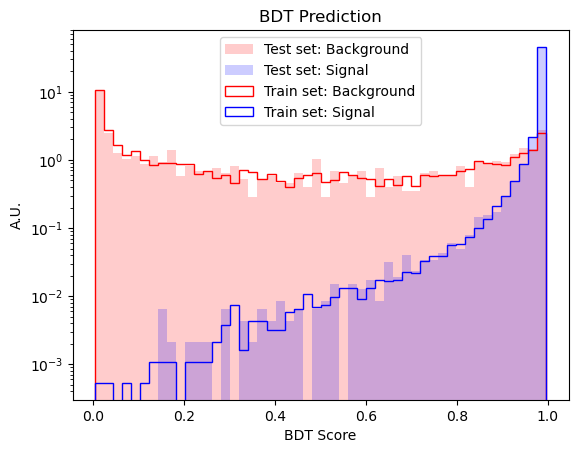

In [301]:
bins = 50

h,bins,_ = plt.hist(pred_test[y_test==0],bins=bins,density=True, histtype='stepfilled', label='Test set: Background', alpha=0.2, color='red')
h,bins,_ = plt.hist(pred_test[y_test==1],bins=bins,density=True, histtype='stepfilled', label='Test set: Signal', alpha=0.2, color='blue')

h,bins,_ = plt.hist(pred_train[y_train==0],bins=bins,density=True, histtype='step', label='Train set: Background',  color='red')
h,bins,_ = plt.hist(pred_train[y_train==1],bins=bins,density=True, histtype='step', label='Train set: Signal', color='blue')

plt.legend()
plt.title('BDT Prediction')

plt.xlabel('BDT Score')
plt.ylabel('A.U.')

plt.yscale('log')

plt.savefig(f'plots/BDT_score_max_depth_{max_depth}_n_estimators_{n_estimators}_lr_{learning_rate}.png')

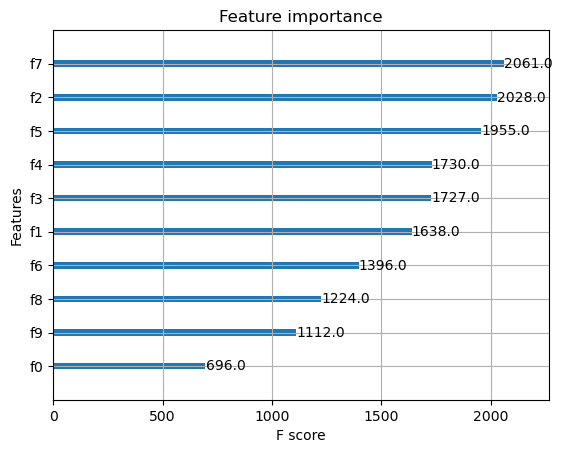

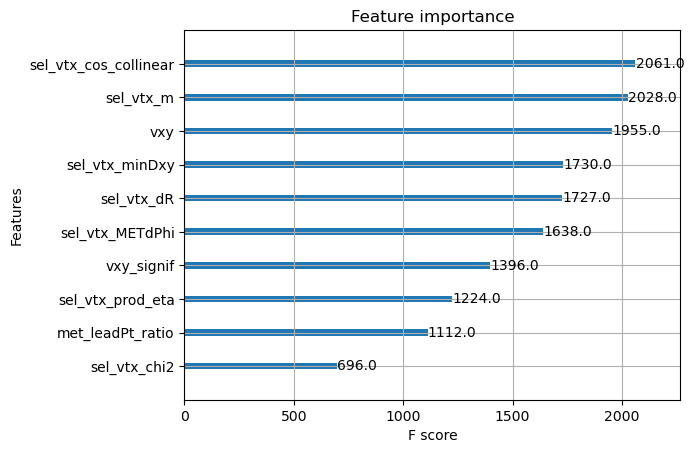

In [302]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(bst)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(bst).set_yticklabels(relabel)

plt.savefig(f'plots/BDT_importance_bst_max_depth_{max_depth}_n_estimators_{n_estimators}_lr_{learning_rate}.png', bbox_inches = "tight")

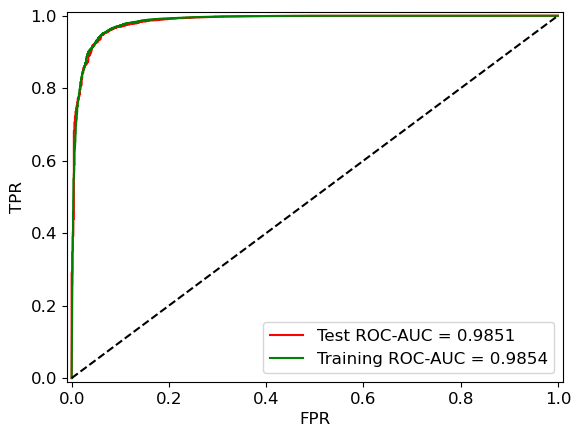

In [303]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# test predictions

fpr, tpr, thresholds = roc_curve(y_test, pred_test)
auc = roc_auc_score(y_test, pred_test)

plt.plot(fpr, tpr, color = "red", label = F"Test ROC-AUC = {auc:.4f}")

# train predictions

fpr, tpr, thresholds = roc_curve(y_train, pred_train)
auc = roc_auc_score(y_train, pred_train)

plt.plot(fpr, tpr, color = "green", label = F"Training ROC-AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)

plt.savefig(f'plots/BDT_roc_curve_max_depth_{max_depth}_n_estimators_{n_estimators}_lr_{learning_rate}.png')

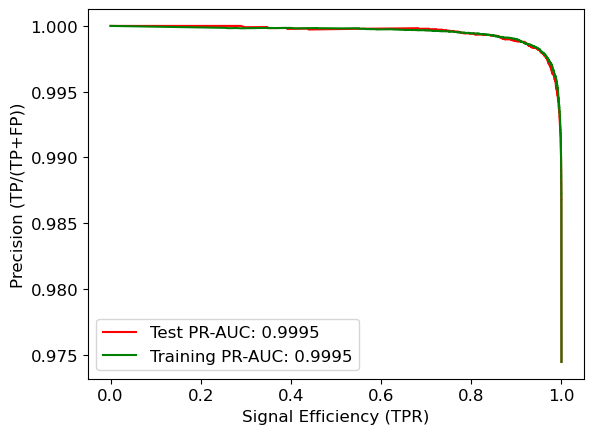

In [304]:
# PR
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import auc

# test predictions

precision, recall, thresholds2 = precision_recall_curve(y_test, pred_test)

plt.plot(recall, precision, color = "red", label=f"Test PR-AUC: {auc(recall, precision):.4f}")

# train predictions

precision, recall, thresholds2 = precision_recall_curve(y_train, pred_train)

plt.plot(recall, precision, color = "green", label=f"Training PR-AUC: {auc(recall, precision):.4f}")

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)
plt.savefig(f'plots/BDT_PR_curve_max_depth_{max_depth}_n_estimators_{n_estimators}_lr_{learning_rate}.png')

### Save and load

In [305]:
os.system(f'mkdir -p models')

0

In [306]:
bst.save_model(f'models/BDT_BJetMedium.json')

### Pearson Correlation

In [307]:
import pandas as pd

df_bkg = pd.DataFrame(bkg_data, columns = variables)
df_sig = pd.DataFrame(sig_data, columns = variables)
df_all = pd.DataFrame(np.concatenate((bkg_data,sig_data),axis=0), columns = variables)

In [308]:
corr_all = df_all.corr()
corr_bkg = df_bkg.corr()
corr_sig = df_sig.corr()

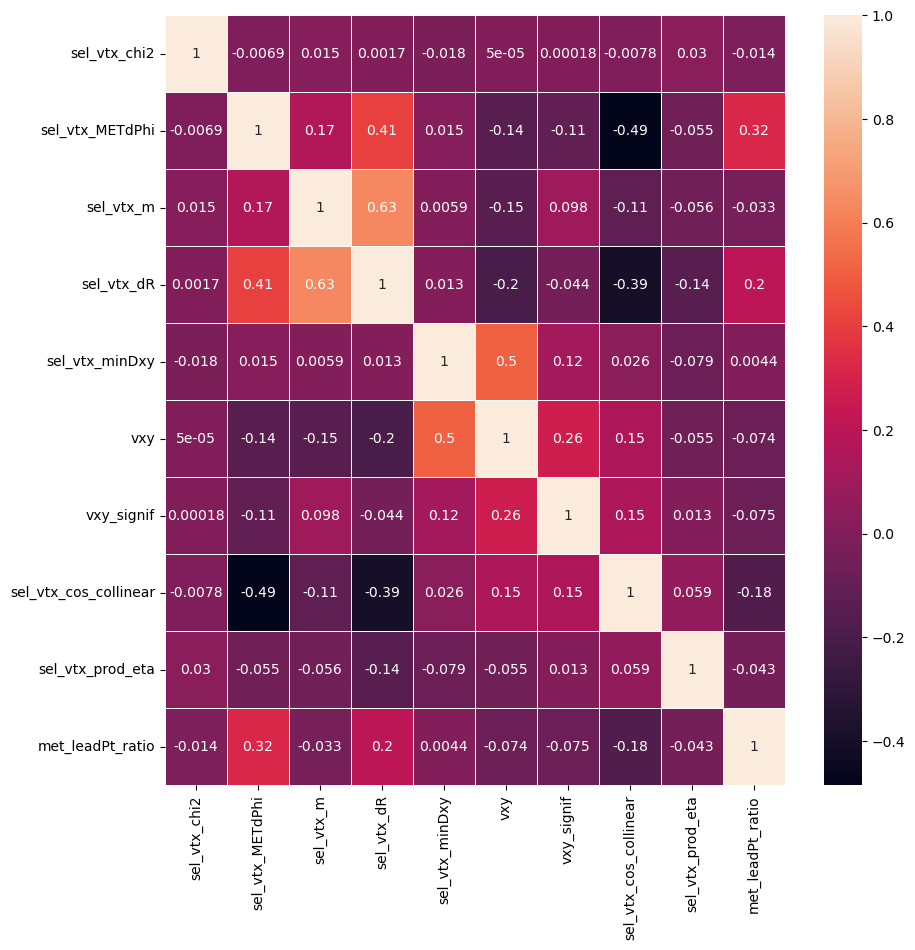

In [309]:
import seaborn as sb
from matplotlib.colors import LogNorm, Normalize

fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_all, annot=True, linewidths=.5)

#plt.savefig('sig_correlation.png')

Text(0.5, 1.0, 'PCC in Background Samples (Dataset size: 4377)')

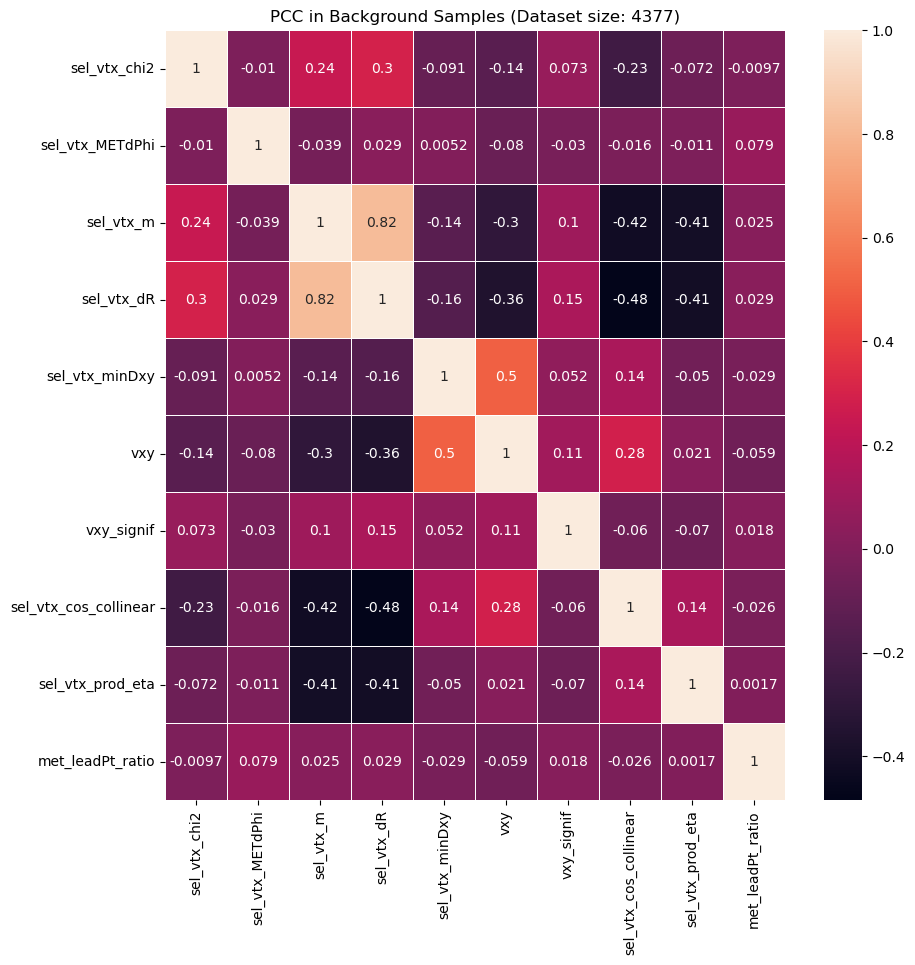

In [310]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_bkg, annot=True, linewidths=.5)
plt.title(f'PCC in Background Samples (Dataset size: {bkg_data.shape[0]})') # Unweighted by xsec

Text(0.5, 1.0, 'PCC in Signal Samples (Dataset size: 166900)')

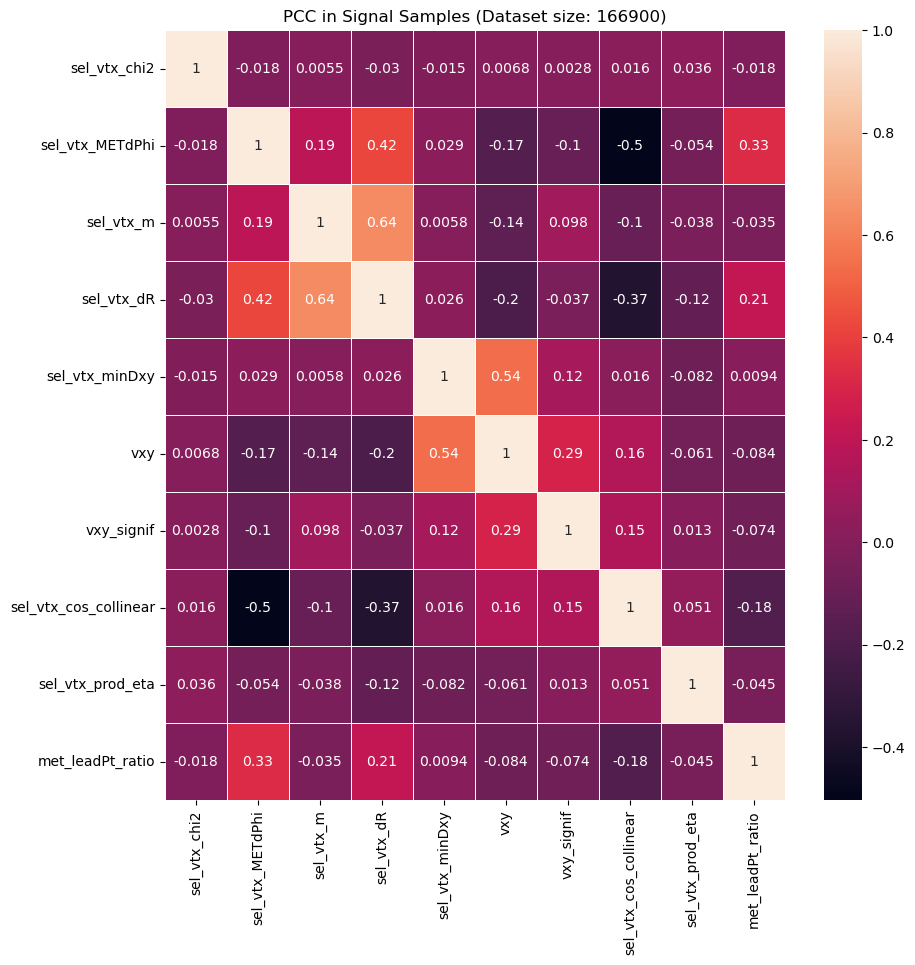

In [311]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sb.heatmap(corr_sig, annot=True, linewidths=.5)
plt.title(f'PCC in Signal Samples (Dataset size: {sig_data.shape[0]})')

In [312]:
trained_model = xgb.XGBRegressor()
trained_model.load_model(f'models/BDT_BJetMedium.json')

In [313]:
pred_test = trained_model.predict(test)
pred_train = trained_model.predict(train)

In [314]:
'''
h_sig = pred_test[y_test == 1]
h_bkg = pred_test[y_test == 0]
'''

'\nh_sig = pred_test[y_test == 1]\nh_bkg = pred_test[y_test == 0]\n'

In [315]:
'''
# S/B scan on the score (xsec unweighted)
h_sig_sum = []
h_bkg_sum = []

for idx, entry in enumerate(h_sig):
    integral = 0
    for j in range(idx):
        integral += h_sig[j]
    h_sig_sum.append(integral)

for idx, entry in enumerate(h_bkg):
    integral = 0
    for j in range(idx):
        integral += h_bkg[j]
    h_bkg_sum.append(integral)

np.array(h_sig_sum)/np.sqrt(h_bkg_sum)
'''

'\n# S/B scan on the score (xsec unweighted)\nh_sig_sum = []\nh_bkg_sum = []\n\nfor idx, entry in enumerate(h_sig):\n    integral = 0\n    for j in range(idx):\n        integral += h_sig[j]\n    h_sig_sum.append(integral)\n\nfor idx, entry in enumerate(h_bkg):\n    integral = 0\n    for j in range(idx):\n        integral += h_bkg[j]\n    h_bkg_sum.append(integral)\n\nnp.array(h_sig_sum)/np.sqrt(h_bkg_sum)\n'

[Text(0, 0, 'sel_vtx_chi2'),
 Text(0, 1, 'met_leadPt_ratio'),
 Text(0, 2, 'sel_vtx_prod_eta'),
 Text(0, 3, 'vxy_signif'),
 Text(0, 4, 'sel_vtx_METdPhi'),
 Text(0, 5, 'sel_vtx_dR'),
 Text(0, 6, 'sel_vtx_minDxy'),
 Text(0, 7, 'vxy'),
 Text(0, 8, 'sel_vtx_m'),
 Text(0, 9, 'sel_vtx_cos_collinear')]

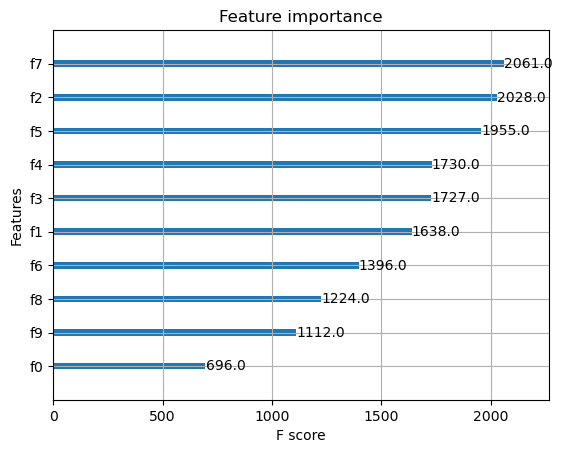

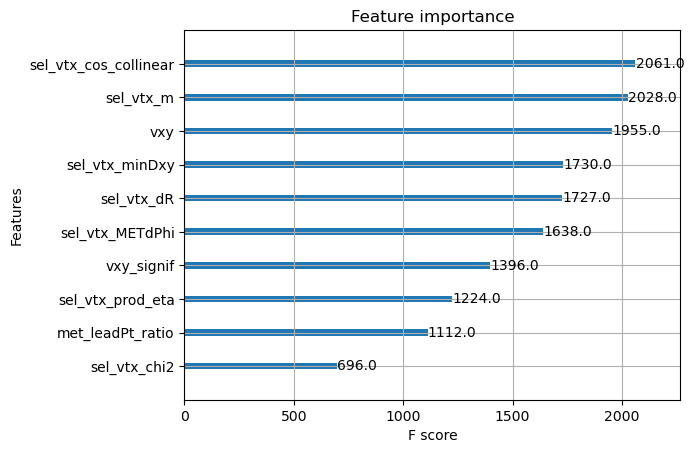

In [316]:
# Label the feature importance plot: replace, i.e. f1 with the variable name lead_jet_pt
label_dict = {}

for idx, var in enumerate(variables):
    label_dict['f{}'.format(idx)] = var
#print(label_dict)

# Plot importance

xgb.plot_importance(trained_model)

ticks = [ item.get_text() for item in plt.gca().get_yticklabels() ]
#print(ticks)
relabel = [ label_dict[tick] for tick in ticks ]
#print(relabel)

# Plot importance with axis with variable names
xgb.plot_importance(trained_model).set_yticklabels(relabel)
#plt.savefig('plots/importance_bst_weighted.png', bbox_inches = "tight")

In [317]:
def get_roc(y_true, y_pred, thres):
    FP = np.count_nonzero((y_true == 0) & (y_pred >= thres))
    TP = np.count_nonzero((y_true == 1) & (y_pred >= thres))
    
    FN = np.count_nonzero((y_true == 1) & (y_pred < thres))
    TN = np.count_nonzero((y_true == 0) & (y_pred < thres))
    
    FPR = FP/(FP+TN)
    TPR = TP/(TP+FN)
    
    s_over_sqrtB = TP/np.sqrt(FP)
    print(f'thres = {thres}, TPR = {TPR}, FPR = {FPR}, s_over_sqrtB = {s_over_sqrtB}')
    
    return TPR, FPR, s_over_sqrtB

In [318]:
def get_roc_auc(y_true, y_pred):
    s_over_sqrtBs = []
    TPRs = []
    FPRs = []
    
    epsilon = 0.005
    scan_range = np.linspace(0+epsilon,1-epsilon,10000)
    for thres in scan_range:
        TPR, FPR, s_over_sqrtB = get_roc(y_true, y_pred, thres)
        TPRs.append(TPR)
        FPRs.append(FPR)
        s_over_sqrtBs.append(s_over_sqrtB)
        
    return TPRs, FPRs, s_over_sqrtBs

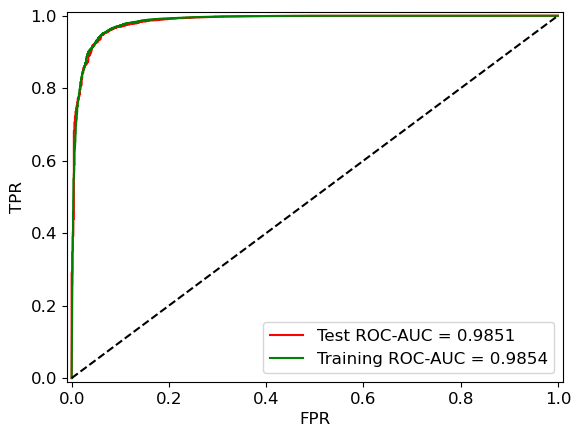

In [319]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

# test predictions

fpr, tpr, thresholds = roc_curve(y_test, pred_test)
auc = roc_auc_score(y_test, pred_test)

plt.plot(fpr, tpr, color = "red", label = F"Test ROC-AUC = {auc:.4f}")

# train predictions

fpr, tpr, thresholds = roc_curve(y_train, pred_train)
auc = roc_auc_score(y_train, pred_train)

plt.plot(fpr, tpr, color = "green", label = F"Training ROC-AUC = {auc:.4f}")

plt.plot([0,1], [0,1] , color = "black", ls = "--")
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('FPR' , fontsize=12)
plt.ylabel('TPR' , fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 4)


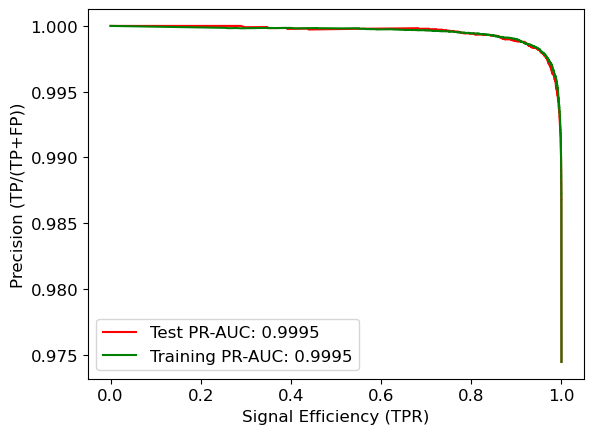

In [320]:
# ROC
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import auc

# test predictions

precision, recall, thresholds2 = precision_recall_curve(y_test, pred_test)

plt.plot(recall, precision, color = "red", label=f"Test PR-AUC: {auc(recall, precision):.4f}")

# train predictions

precision, recall, thresholds2 = precision_recall_curve(y_train, pred_train)

plt.plot(recall, precision, color = "green", label=f"Training PR-AUC: {auc(recall, precision):.4f}")

plt.ylabel('Precision (TP/(TP+FP))', fontsize=12)
plt.xlabel('Signal Efficiency (TPR)', fontsize=12)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend( prop={'size':12} , loc = 3)

### WP for a given signal efficiency

In [321]:
idx_valid = thresholds < 1

tpr = tpr[idx_valid]
thresholds = thresholds[idx_valid]

In [322]:
tpr_WP = {'tight': 0.7, 'medium': 0.85, 'loose': 0.9}
thres_WP = {'tight': 0, 'medium': 0, 'loose': 0}

In [323]:
epsilon = 0.005

for wp in tpr_WP.keys():    
    idx = np.where((tpr > tpr_WP[wp] - epsilon) & (tpr < tpr_WP[wp] + epsilon))
    
    thres_WP[wp] = thresholds[idx].mean()

    print(f'{wp} threshold: {thres_WP[wp]}')

tight threshold: 0.9933103322982788
medium threshold: 0.9886969923973083
loose threshold: 0.9834728240966797


### TPR, FPR, Significance with raw and weighted counts for WP scan

In [324]:
# bkg 

thres = 0.9928

nbkg_total = np.sum(test_xsec_norm[(test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)])
nbkg_pass = np.sum(test_xsec_norm[((test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)) & (pred_test > thres)])

print(f'nbkg_pass / nbkg_total = {nbkg_pass:.2f} / {nbkg_total:.2f}')

nbkg_pass / nbkg_total = 1.39 / 192.13


In [325]:
# bkg 

thres = 0.9928


bkg_train_total = train_xsec_norm[(train_m1 == 0) & (train_delta == 0) & (train_ctau == 0)]
bkg_train_pass = train_xsec_norm[((train_m1 == 0) & (train_delta == 0) & (train_ctau == 0)) & (pred_train > thres)]

bkg_test_total = test_xsec_norm[(test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)]
bkg_test_pass = test_xsec_norm[((test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)) & (pred_test > thres)]

nbkg_train_total = np.sum(bkg_train_total)
nbkg_train_pass = np.sum(bkg_train_pass)

nbkg_test_total = np.sum(bkg_test_total)
nbkg_test_pass = np.sum(bkg_test_pass)

print(f'nbkg_train_pass / nbkg_train_total = {nbkg_train_pass:.2f} / {nbkg_train_total:.2f}')
print(f'nbkg_test_pass / nbkg_test_total = {nbkg_test_pass:.2f} / {nbkg_test_total:.2f}')

print(f'nbkg_pass / nbkg_total = {nbkg_train_pass+nbkg_test_pass:.2f} / {nbkg_train_total+nbkg_test_total:.2f}')

nbkg_train_pass / nbkg_train_total = 7.40 / 823.63
nbkg_test_pass / nbkg_test_total = 1.39 / 192.13
nbkg_pass / nbkg_total = 8.80 / 1015.76


In [326]:
# bkg 
bkg_train_total = train_xsec_norm[(train_m1 == 0) & (train_delta == 0) & (train_ctau == 0)]
bkg_train_pass = train_xsec_norm[((train_m1 == 0) & (train_delta == 0) & (train_ctau == 0)) & (pred_train > thres)]

bkg_test_total = test_xsec_norm[(test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)]
bkg_test_pass = test_xsec_norm[((test_m1 == 0) & (test_delta == 0) & (test_ctau == 0)) & (pred_test > thres)]

nbkg_train_total = np.sum(bkg_train_total)
nbkg_train_pass = np.sum(bkg_train_pass)

nbkg_test_total = np.sum(bkg_test_total)
nbkg_test_pass = np.sum(bkg_test_pass)

print(f'nbkg_train_pass / nbkg_train_total = {nbkg_train_pass:.2f} / {nbkg_train_total:.2f}')
print(f'nbkg_test_pass / nbkg_test_total = {nbkg_test_pass:.2f} / {nbkg_test_total:.2f}')

print(f'nbkg_pass / nbkg_total = {nbkg_train_pass+nbkg_test_pass:.2f} / {nbkg_train_total+nbkg_test_total:.2f}')

nbkg_train_pass / nbkg_train_total = 7.40 / 823.63
nbkg_test_pass / nbkg_test_total = 1.39 / 192.13
nbkg_pass / nbkg_total = 8.80 / 1015.76


In [327]:
# thres = 0.9928

In [328]:
def getEntries(thres, m1, delta, ctau, isRaw = False, isTest = False):
    train_total_weighted = np.sum(train_xsec_norm[(train_m1 == m1) & (train_delta == delta) & (train_ctau == ctau)])
    train_total_raw = len(train_xsec_norm[(train_m1 == m1) & (train_delta == delta) & (train_ctau == ctau)])
    
    train_pass_weighted = np.sum(train_xsec_norm[(train_m1 == m1) & (train_delta == delta) & (train_ctau == ctau) & (pred_train > thres)])
    train_pass_raw = len(train_xsec_norm[(train_m1 == m1) & (train_delta == delta) & (train_ctau == ctau) & (pred_train > thres)])
    
    test_total_weighted = np.sum(test_xsec_norm[(test_m1 == m1) & (test_delta == delta) & (test_ctau == ctau)])
    test_total_raw = len(test_xsec_norm[(test_m1 == m1) & (test_delta == delta) & (test_ctau == ctau)])
    
    test_pass_weighted = np.sum(test_xsec_norm[(test_m1 == m1) & (test_delta == delta) & (test_ctau == ctau) & (pred_test > thres)])
    test_pass_raw = len(test_xsec_norm[(test_m1 == m1) & (test_delta == delta) & (test_ctau == ctau) & (pred_test > thres)])
    
    total_weighted = train_total_weighted + test_total_weighted
    total_raw = train_total_raw + test_total_raw
    
    pass_weighted = train_pass_weighted + test_pass_weighted
    pass_raw = train_pass_raw + test_pass_raw

    if isRaw:
        if isTest:
            nPass = test_pass_raw
            nTotal = test_total_raw
        else:
            nPass = pass_raw
            nTotal = total_raw
    else:
        if isTest:
            nPass = test_pass_weighted
            nTotal = test_total_weighted
        else:
            nPass = pass_weighted
            nTotal = total_weighted
        
    return nPass, nTotal

In [329]:
def longSignif(s, b):
    #b_sigma = np.sqrt(b)
    c = 0.1
    b_sigma = np.array(b) * c
    
    term1 = (s+b) * np.log(((s+b) * (b+ (b_sigma**2)))/(b**2 + (s+b)*(b_sigma**2)))
    term2 = (b**2 / (b_sigma**2)) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))
    #term2 = (c**2) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))

    return np.sqrt(2*(term1 - term2))

In [330]:
def longSignif_sigma(s, b):
    b_sigma = np.sqrt(b)
    #c = 0.1
    #b_sigma = np.array(b) * c

    s = np.array(s)
    b = np.array(b)
    
    term1 = (s+b) * np.log(((s+b) * (b+ (b_sigma**2)))/(b**2 + (s+b)*(b_sigma**2)))
    term2 = (b**2 / (b_sigma**2)) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))
    #term2 = (c**2) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))

    return np.sqrt(2*(term1 - term2))

In [331]:
def longSignif_rel(s, b):
    #b_sigma = np.sqrt(b)
    c = 0.1
    b_sigma = np.array(b) * c

    s = np.array(s)
    b = np.array(b)
    
    term1 = (s+b) * np.log(((s+b) * (b+ (b_sigma**2)))/(b**2 + (s+b)*(b_sigma**2)))
    term2 = (b**2 / (b_sigma**2)) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))
    #term2 = (c**2) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))

    return np.sqrt(2*(term1 - term2))

In [332]:
def scan_TPR_SoverSqrtB(m1, delta, ctau, isRaw, isTest):
    thres_arr = np.linspace(0, 1, 1000)
    s_over_sqrtB = []
    longsignif_sigma = []
    longsignif_rel = []
    s_TPR = []
    s_count = []

    for thres in thres_arr:
        #print(thres)
        s_pass, s_total = getEntries(thres, m1, delta, ctau, isRaw = isRaw, isTest = isTest)
        
        b_pass, b_total = getEntries(thres, 0, 0, 0, isRaw = isRaw, isTest = isTest)
    
        s_over_sqrtB.append(s_pass / np.sqrt(b_pass))
        s_TPR.append(s_pass/np.array(s_total))

        s_count.append(s_pass)

        longsignif_sigma.append(longSignif_sigma(s_pass, b_pass))
        longsignif_rel.append(longSignif_rel(s_pass, b_pass))

    return s_over_sqrtB, longsignif_sigma, longsignif_rel, s_count, s_TPR, thres_arr

In [333]:
def scan_FPR(isRaw, isTest):
    thres_arr = np.linspace(0, 1, 1000)
    b_FPR = []
    b_count = []

    for thres in thres_arr:
        b_pass, b_total = getEntries(thres, 0, 0, 0, isRaw = isRaw, isTest = isTest)
    
        b_FPR.append(b_pass/b_total)

        b_count.append(b_pass)
    
    return b_FPR, b_count, thres_arr

In [334]:
b_FPR_raw, b_count_raw, thres_arr = scan_FPR(isRaw = True, isTest = False)
b_FPR_raw_test, b_count_raw_test, thres_arr_test = scan_FPR(isRaw = True, isTest = True)

In [335]:
b_FPR_weighted, b_count_weighted, thres_arr = scan_FPR(isRaw = False, isTest = False)
b_FPR_weighted_test, b_count_weighted_test, thres_arr = scan_FPR(isRaw = False, isTest = True)

In [336]:
s_over_sqrtB_raw = {}
longsignif_sqrt_raw = {}
longsignif_rel_raw = {}
s_count_raw = {}
s_TPR_raw = {}
thres_arr = {}

s_over_sqrtB_raw_test = {}
longsignif_sqrt_raw_test = {}
longsignif_rel_raw_test = {}
s_count_raw_test = {}
s_TPR_raw_test = {}
thres_arr_test = {}

s_over_sqrtB_weighted = {}
longsignif_sqrt_weighted = {}
longsignif_rel_weighted = {}
s_count_weighted = {}
s_TPR_weighted = {}

s_over_sqrtB_weighted_test = {}
longsignif_sqrt_weighted_test = {}
longsignif_rel_weighted_test = {}
s_count_weighted_test = {}
s_TPR_weighted_test = {}

In [337]:
for m1 in [5, 10, 20, 30, 40, 50, 70, 90, 100]:
    for delta in [0.1, 0.2]:
        for ctau in [1, 10, 100]:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            s_over_sqrtB_raw[point], longsignif_sqrt_raw[point], longsignif_rel_raw[point], s_count_raw[point], s_TPR_raw[point], thres_arr[point] = scan_TPR_SoverSqrtB(m1, delta, ctau, isRaw = True, isTest = False)
            s_over_sqrtB_raw_test[point], longsignif_sqrt_raw_test[point], longsignif_rel_raw_test[point], s_count_raw_test[point], s_TPR_raw_test[point], thres_arr_test[point] = scan_TPR_SoverSqrtB(m1, delta, ctau, isRaw = True, isTest = True)
            
            s_over_sqrtB_weighted[point], longsignif_sqrt_weighted[point], longsignif_rel_weighted[point], s_count_weighted[point], s_TPR_weighted[point], thres_arr[point] = scan_TPR_SoverSqrtB(m1, delta, ctau, isRaw = False, isTest = False)
            s_over_sqrtB_weighted_test[point], longsignif_sqrt_weighted_test[point], longsignif_rel_weighted_test[point], s_count_weighted_test[point], s_TPR_weighted_test[point], thres_arr_test[point] = scan_TPR_SoverSqrtB(m1, delta, ctau, isRaw = False, isTest = True)

/tmp/ipykernel_2652702/636468158.py:15: RuntimeWarning: invalid value encountered in scalar divide
  s_over_sqrtB.append(s_pass / np.sqrt(b_pass))
/tmp/ipykernel_2652702/3232277458.py:9: RuntimeWarning: invalid value encountered in scalar divide
  term1 = (s+b) * np.log(((s+b) * (b+ (b_sigma**2)))/(b**2 + (s+b)*(b_sigma**2)))
/tmp/ipykernel_2652702/3232277458.py:10: RuntimeWarning: invalid value encountered in scalar divide
  term2 = (b**2 / (b_sigma**2)) * np.log(1+ ((b_sigma**2)*s)/(b*(b+(b_sigma**2))))
/tmp/ipykernel_2652702/3232277458.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(2*(term1 - term2))


In [338]:
from matplotlib.lines import Line2D

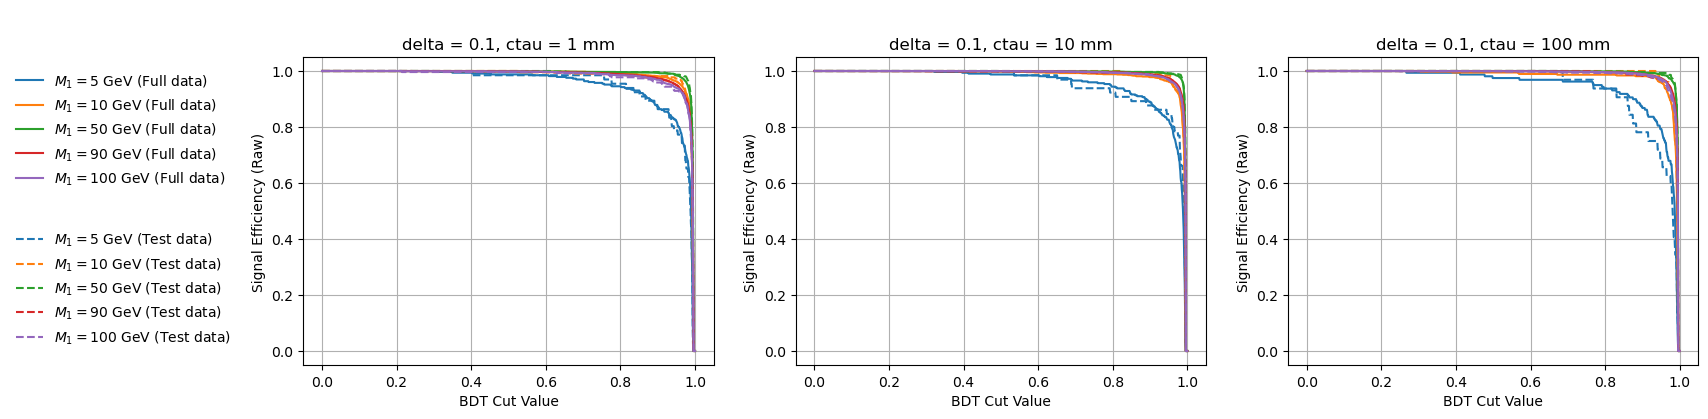

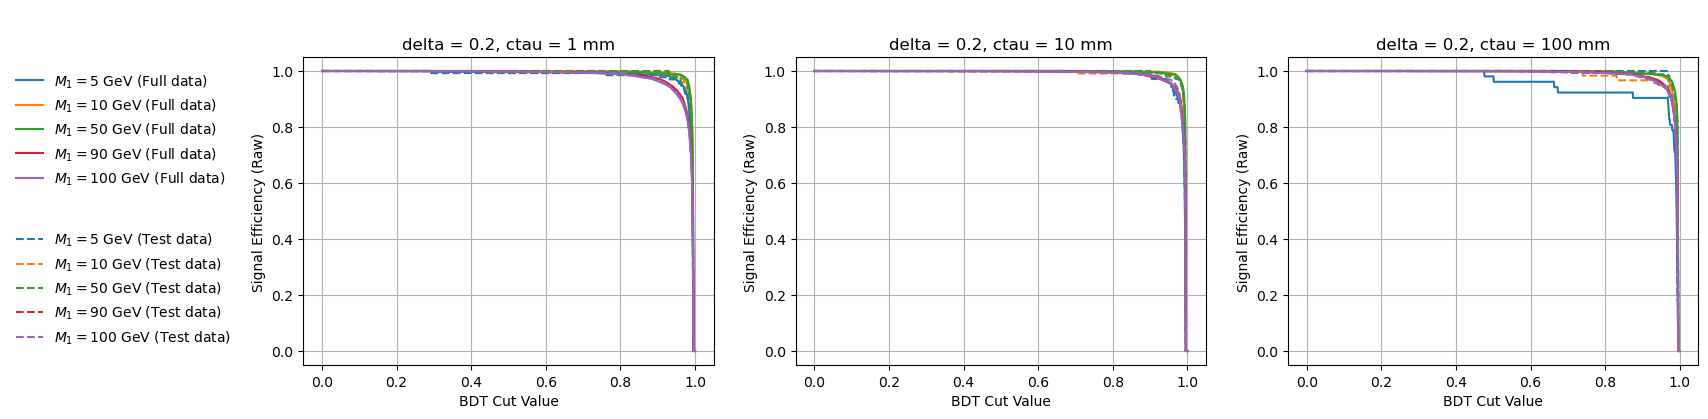

In [339]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(s_TPR_raw[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(s_TPR_raw_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Signal Efficiency (Raw)')
    
        #axes[idx].set_yscale('log')

        #axes[idx].set_xlim([0.7,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

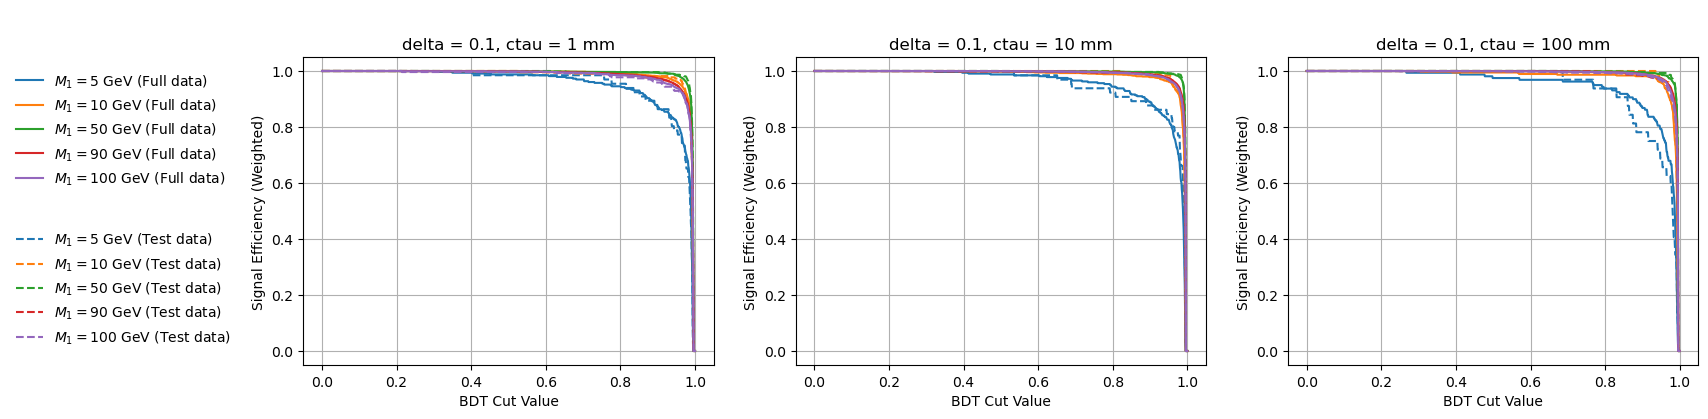

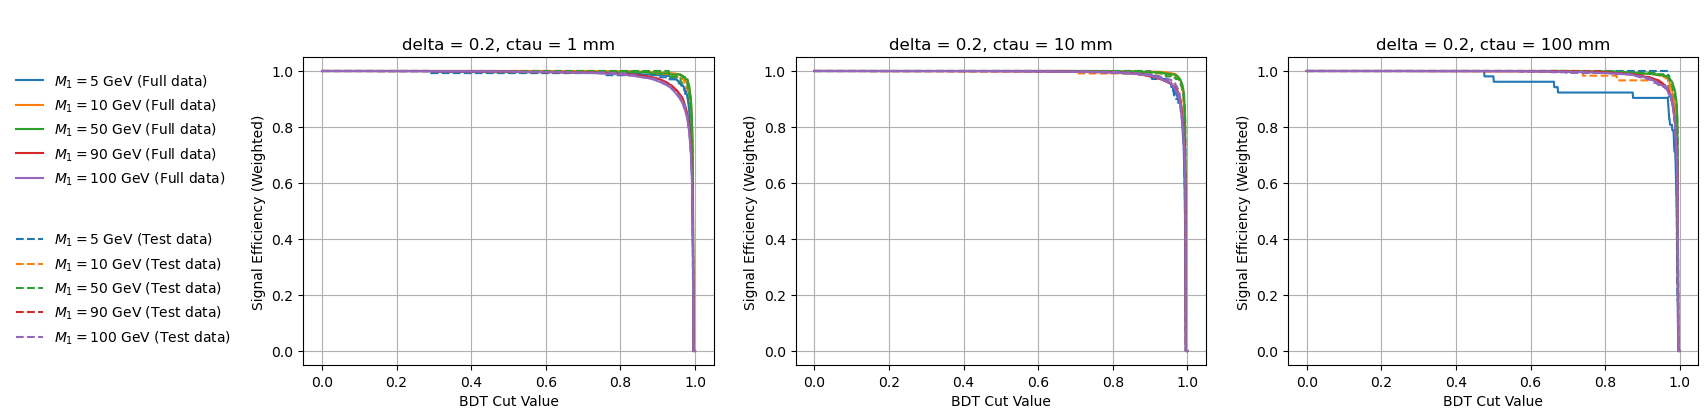

In [340]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(s_TPR_weighted[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(s_TPR_weighted_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Signal Efficiency (Weighted)')
    
        #axes[idx].set_yscale('log')

        #axes[idx].set_xlim([0.7,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

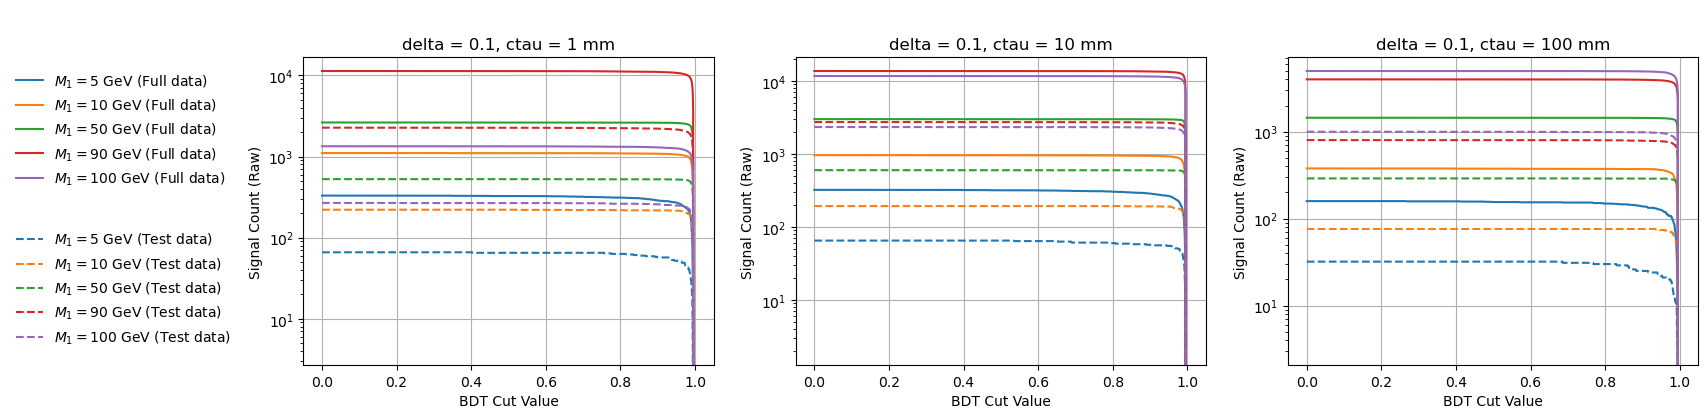

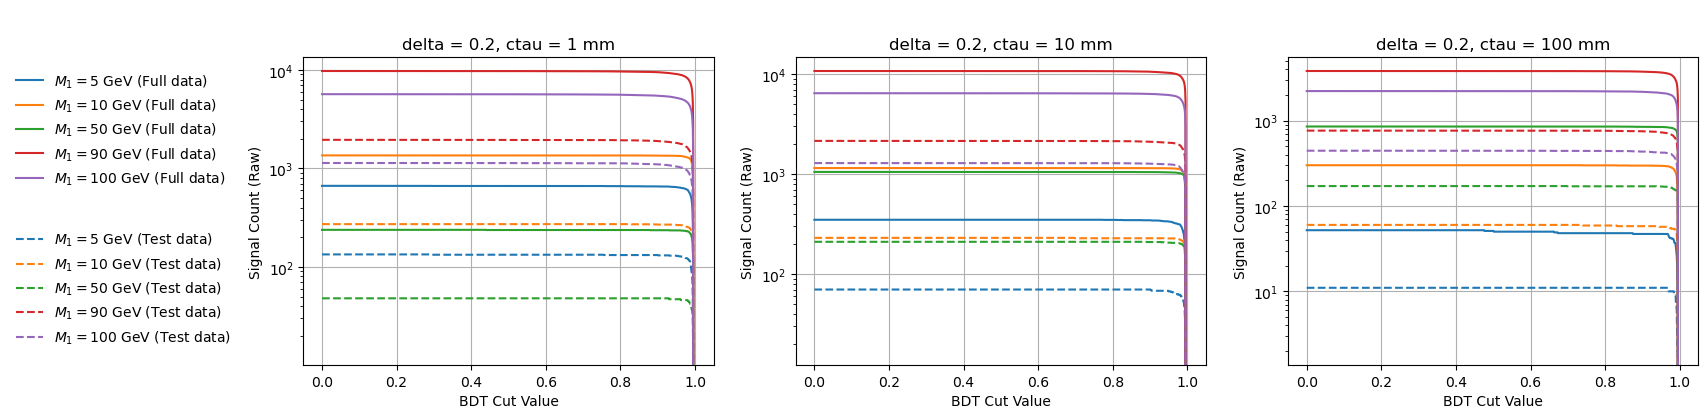

In [341]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(s_count_raw[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(s_count_raw_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Signal Count (Raw)')
    
        axes[idx].set_yscale('log')

        #axes[idx].set_xlim([0.7,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

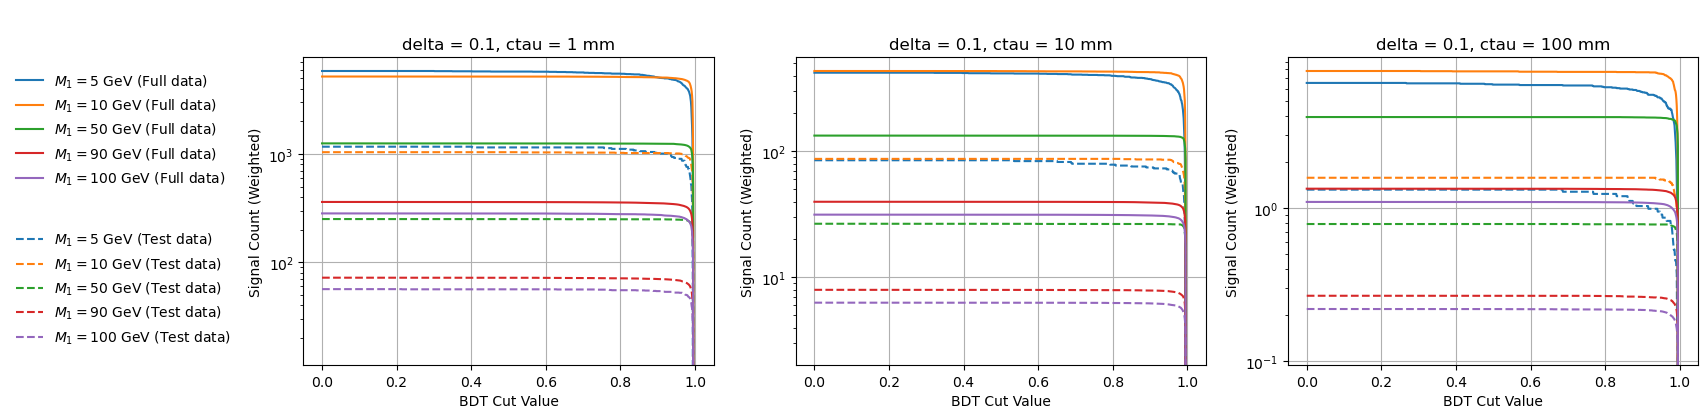

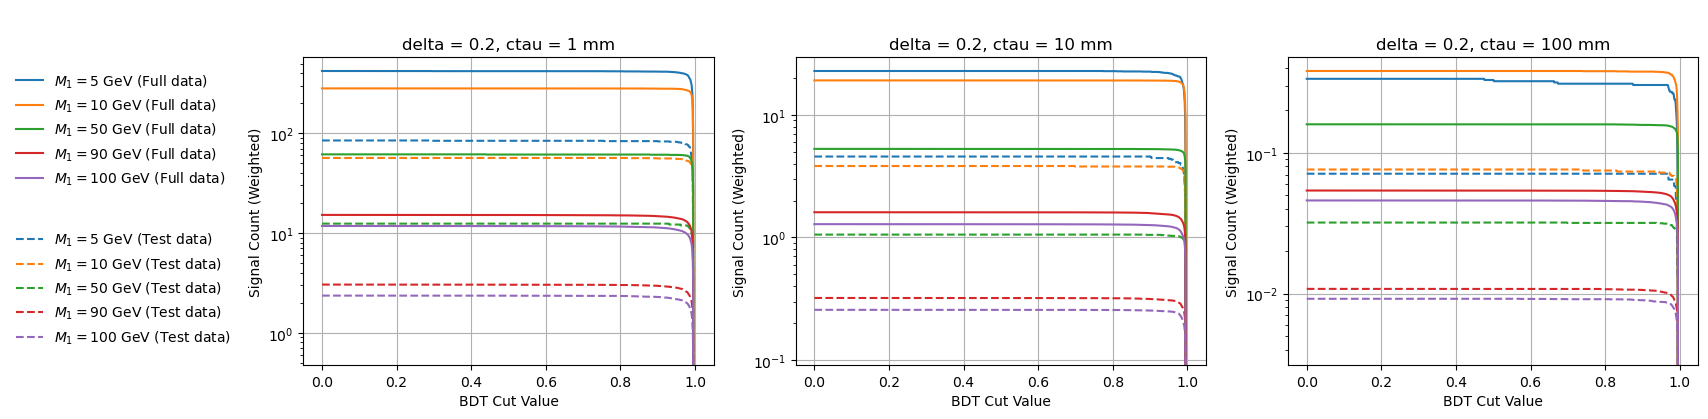

In [342]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(s_count_weighted[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(s_count_weighted_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Signal Count (Weighted)')
    
        axes[idx].set_yscale('log')

        #axes[idx].set_xlim([0.7,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

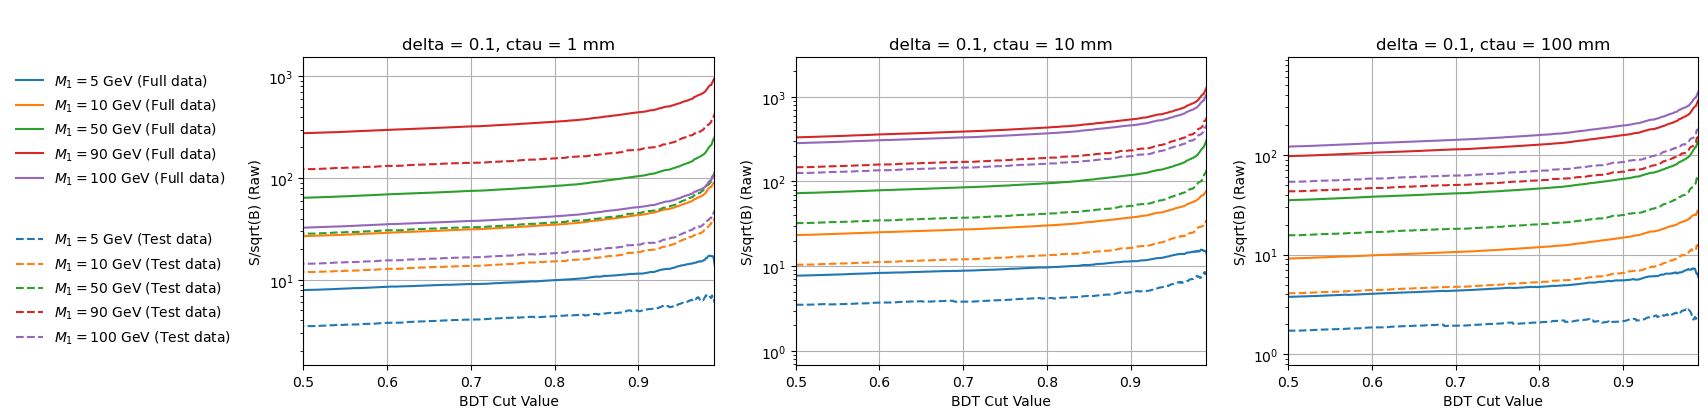

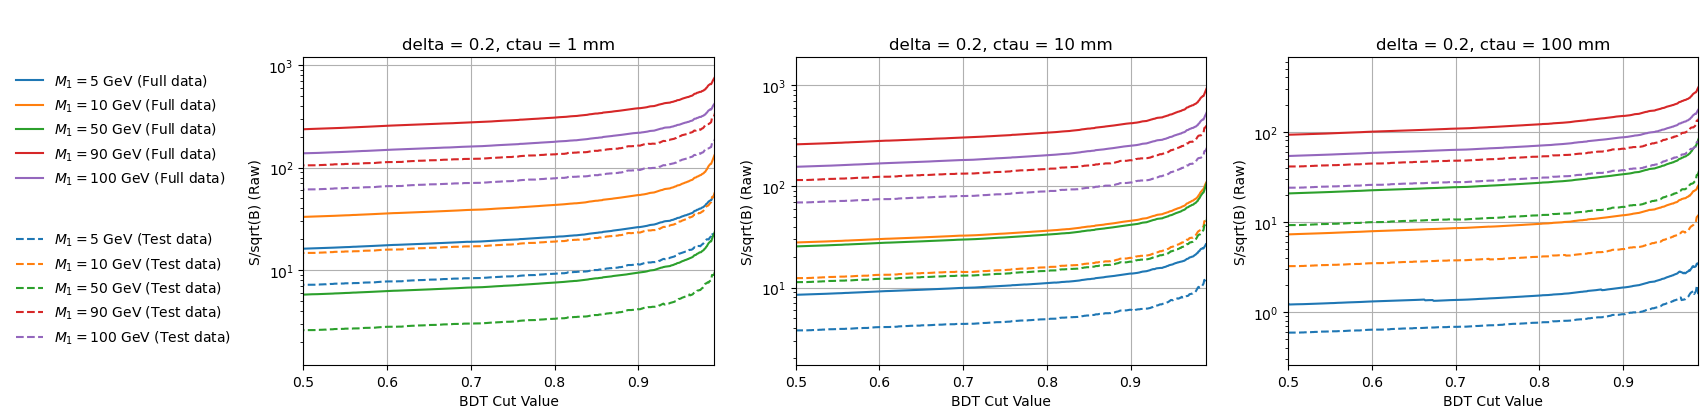

In [343]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(s_over_sqrtB_raw[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(s_over_sqrtB_raw_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('S/sqrt(B) (Raw)')
    
        axes[idx].set_yscale('log')

        axes[idx].set_xlim([0.5,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

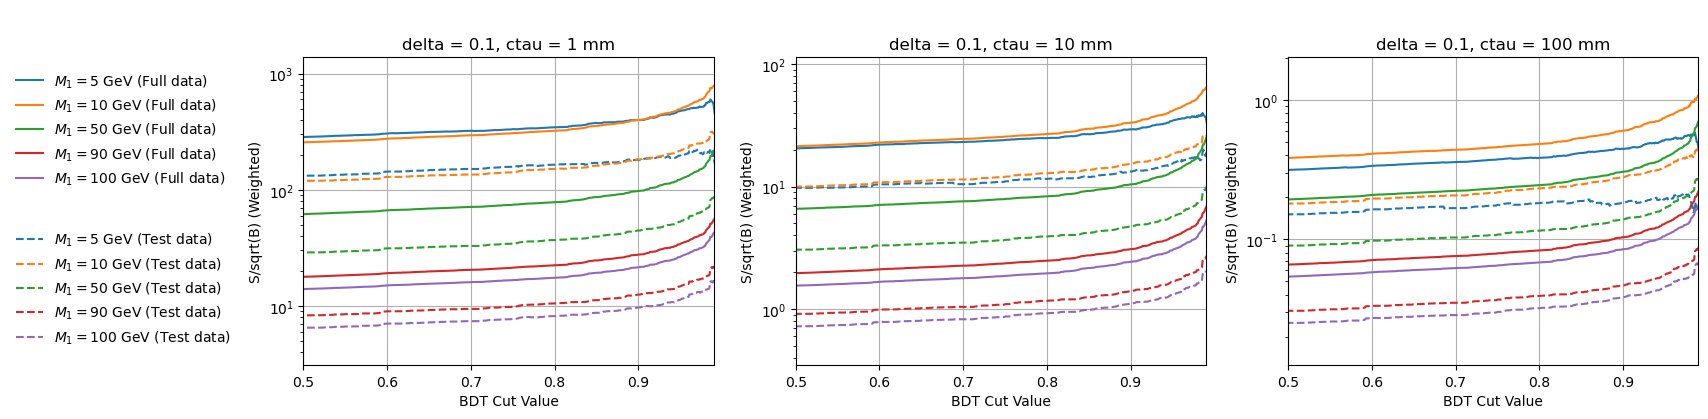

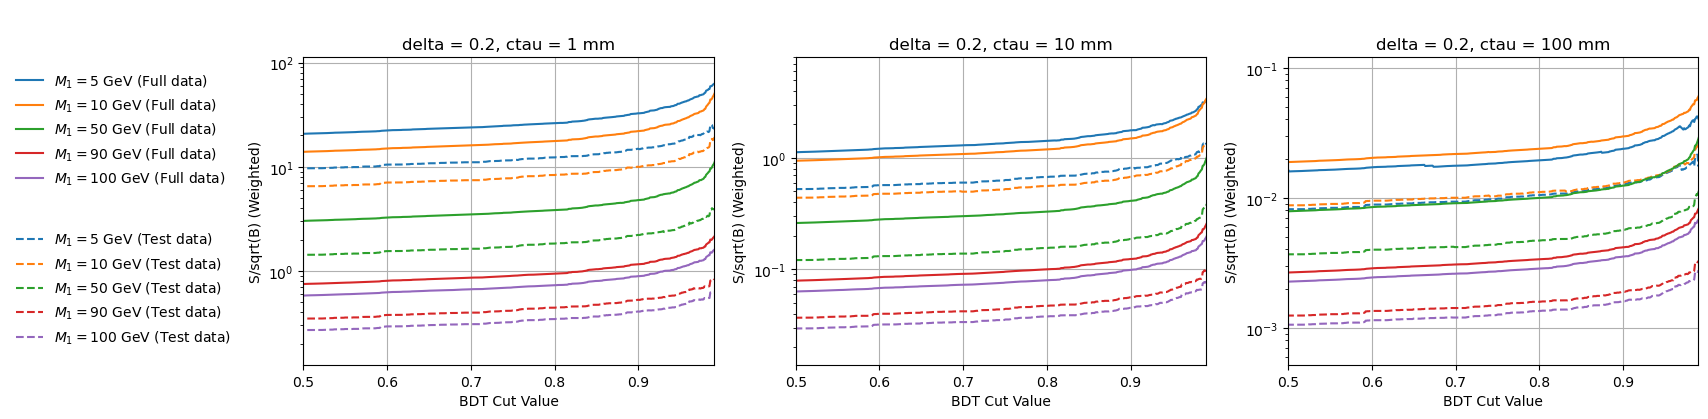

In [344]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(s_over_sqrtB_weighted[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(s_over_sqrtB_weighted_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('S/sqrt(B) (Weighted)')
    
        axes[idx].set_yscale('log')

        axes[idx].set_xlim([0.5,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

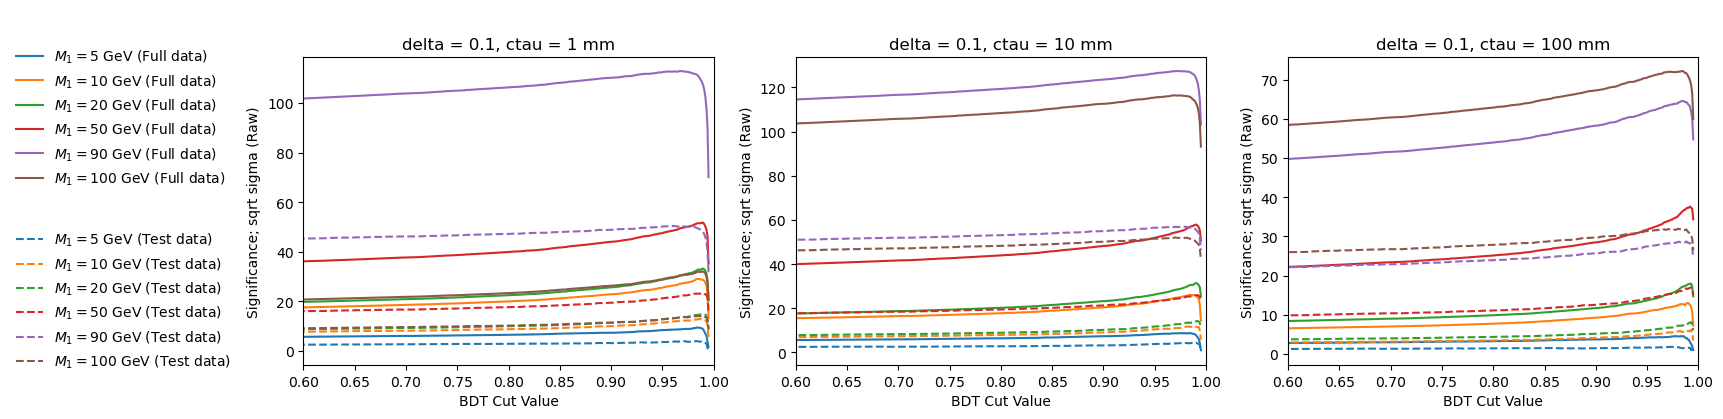

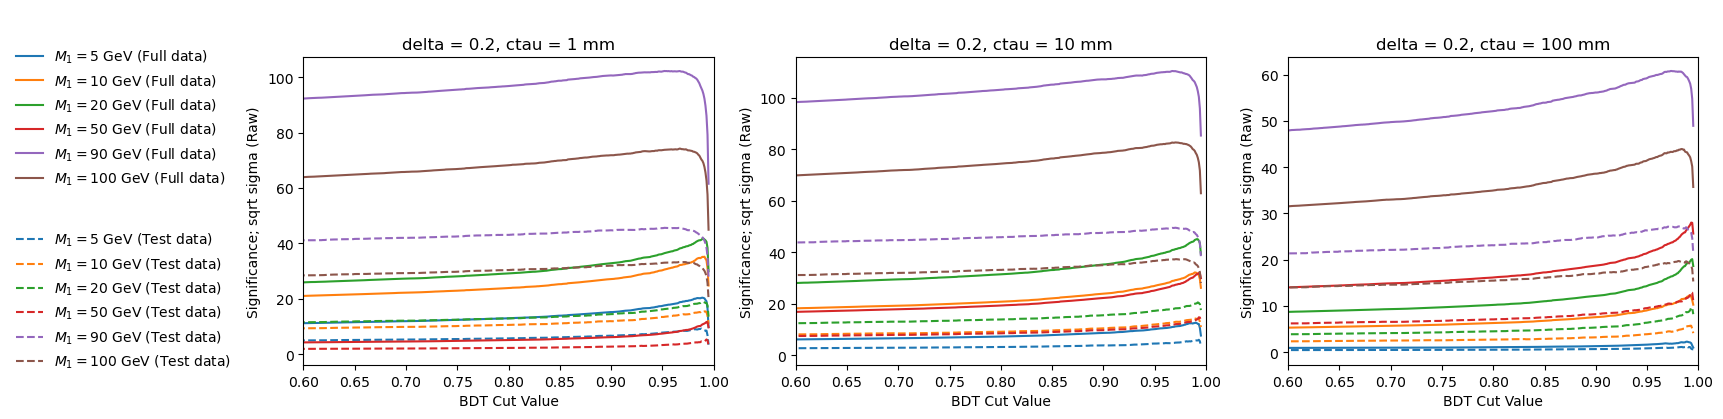

In [345]:
#m1s = [100]
m1s = [5, 10, 20, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(longsignif_sqrt_raw[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(longsignif_sqrt_raw_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Significance; sqrt sigma (Raw)')
    
        #axes[idx].set_yscale('log')

        axes[idx].set_xlim([0.6,1]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

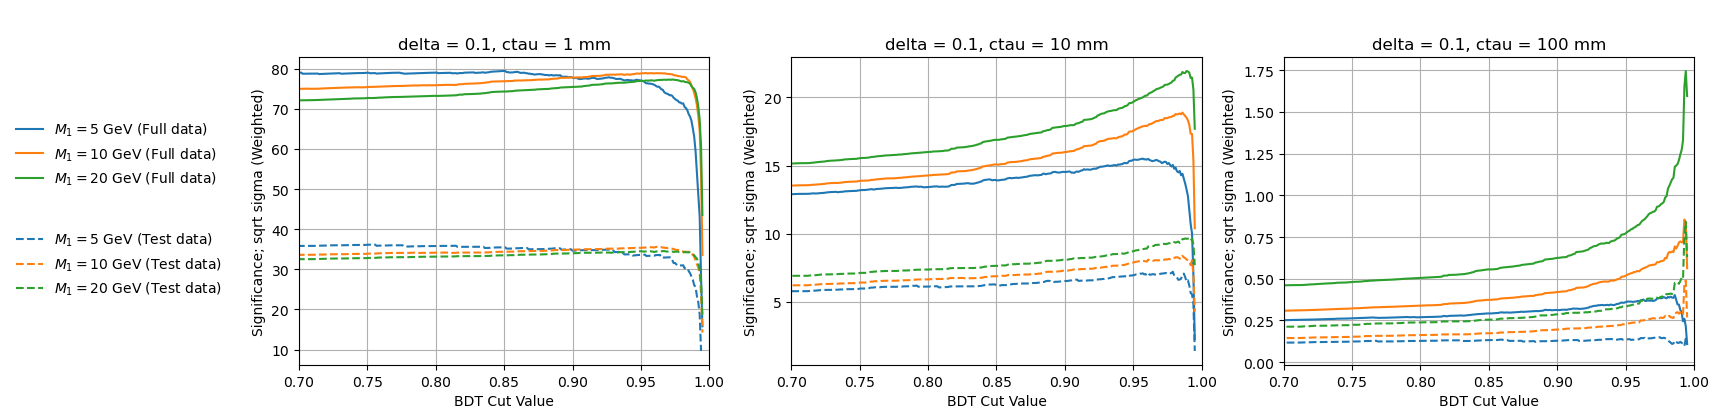

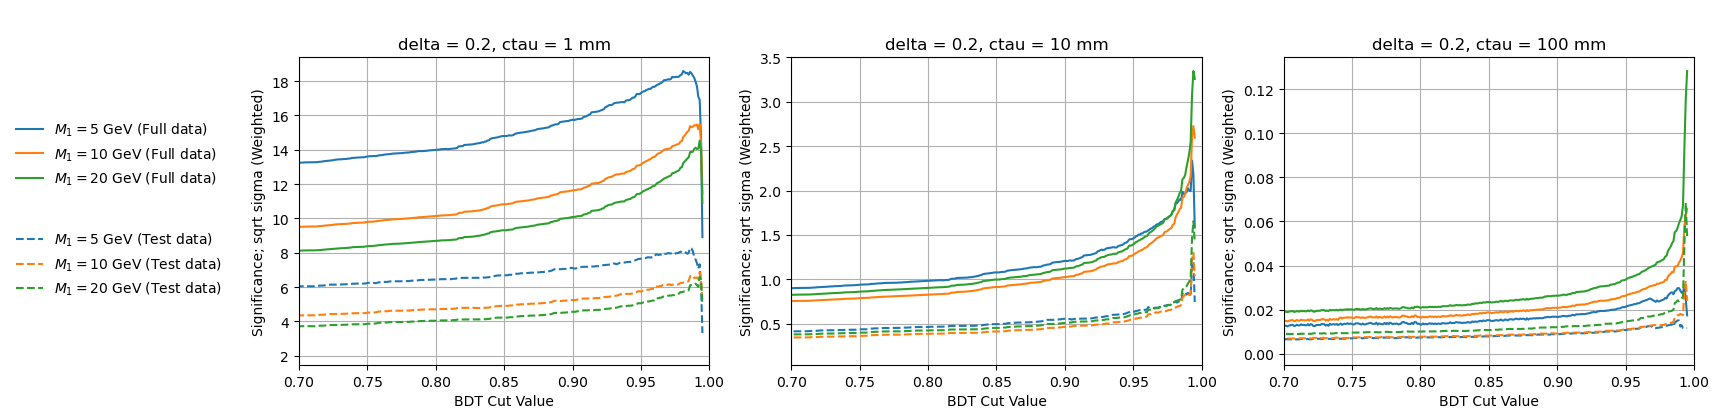

In [346]:
#m1s = [100]
m1s = [5, 10, 20]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(longsignif_sqrt_weighted[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(longsignif_sqrt_weighted_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Significance; sqrt sigma (Weighted)')
    
        #axes[idx].set_yscale('log')

        axes[idx].set_xlim([0.7,1]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

[0.984984984984985, 0.988988988988989, 0.988988988988989, 0.988988988988989, 0.988988988988989, 0.985985985985986, 0.9669669669669669, 0.988988988988989]
[0.984984984984985, 0.990990990990991, 0.98998998998999, 0.98998998998999, 0.98998998998999, 0.988988988988989, 0.9729729729729729, 0.96996996996997]
[0.988988988988989, 0.992992992992993, 0.990990990990991, 0.990990990990991, 0.991991991991992, 0.991991991991992, 0.984984984984985, 0.983983983983984]


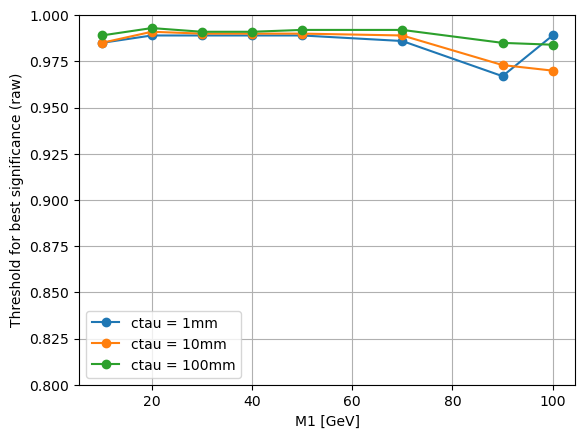

In [347]:
m1s = [10, 20, 30, 40, 50, 70, 90, 100]

delta = 0.1
#ctau = 1

for ctau in [1, 10, 100]:
    best_thres = []
    
    for m1 in m1s:
        point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
    
        arr = longsignif_sqrt_raw[point]
        arr = np.nan_to_num(arr)
        best_thres.append(thres_arr[point][np.argmax(arr)])
    print(best_thres)

    plt.plot(m1s, best_thres, '-o', label=f'ctau = {ctau}mm')
    
plt.xlabel('M1 [GeV]')
plt.ylabel('Threshold for best significance (raw)')

plt.grid()
plt.ylim([0.8, 1])

plt.legend()

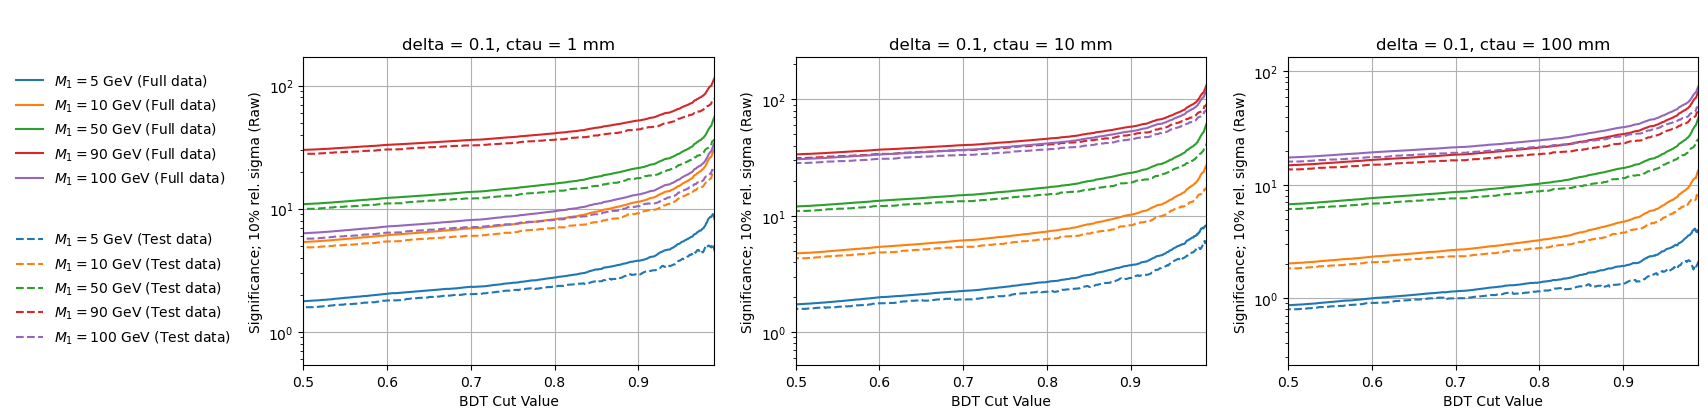

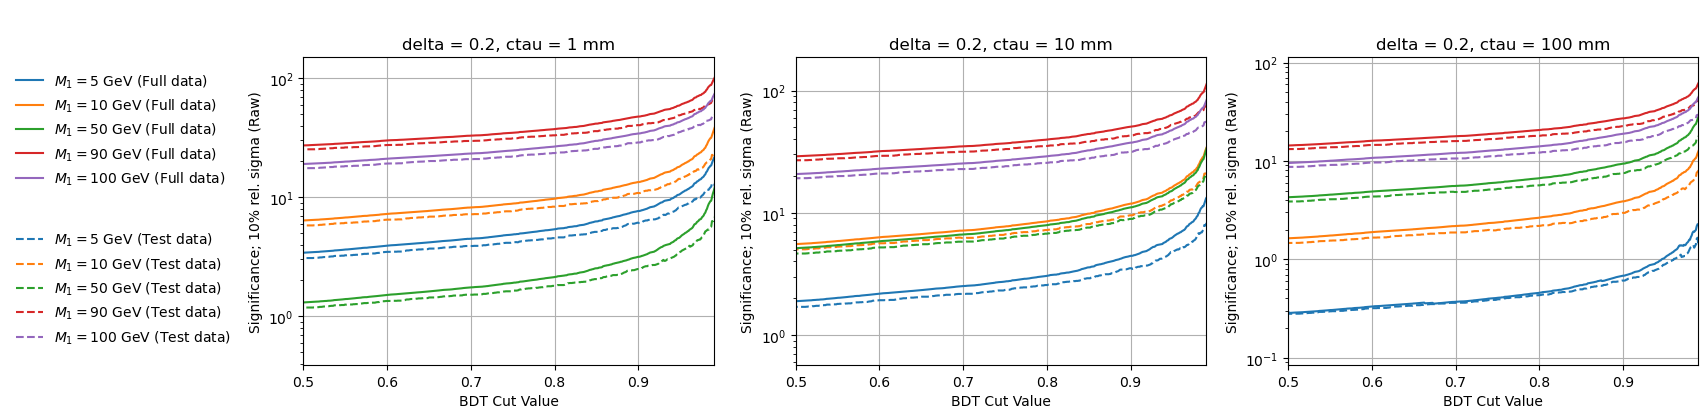

In [348]:
#m1s = [100]
m1s = [5, 10, 50, 90, 100]
ctaus = [1, 10, 100]
deltas = [0.1, 0.2]

for delta in deltas:
    fig,axes = plt.subplots(1,3,figsize=(18,4))
    
    massColors = {m1s[i]:f"C{i}" for i in range(len(m1s))}
    lines = [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Full data)", color=massColors[m]) for m in sorted(list(massColors.keys()))]
    lines += [Line2D([0], [0], label="\n", color='white')] # add a "break line"
    lines += [Line2D([0], [0], label=f"$M_1 = {m}$ GeV (Test data)", color=massColors[m], linestyle='dashed') for m in sorted(list(massColors.keys()))]
    
    for idx, ctau in enumerate(ctaus):
        for m1 in m1s:
            point = f'm1_{m1}_delta_{delta}_ctau_{ctau}'
            
            axes[idx].plot(thres_arr[point], np.array(longsignif_rel_raw[point]), label='Training + Test Set', color=massColors[m1])
            axes[idx].plot(thres_arr_test[point], np.array(longsignif_rel_raw_test[point]), label='Test Set', linestyle='dashed', color=massColors[m1])

            axes[idx].grid()
            
        axes[idx].set_title(f'delta = {delta}, ctau = {ctau} mm')
        axes[idx].set_xlabel('BDT Cut Value')
        axes[idx].set_ylabel('Significance; 10% rel. sigma (Raw)')
    
        axes[idx].set_yscale('log')

        axes[idx].set_xlim([0.5,0.99]) 
    
    legend_ax = fig.add_axes([0, 0, 0.05, 1])  # Adjust the values as needed
    legend_ax.axis('off')
    legend_ax.legend(handles=lines,loc='center',frameon=False)

Text(0.5, 1.0, 'Using raw event count')

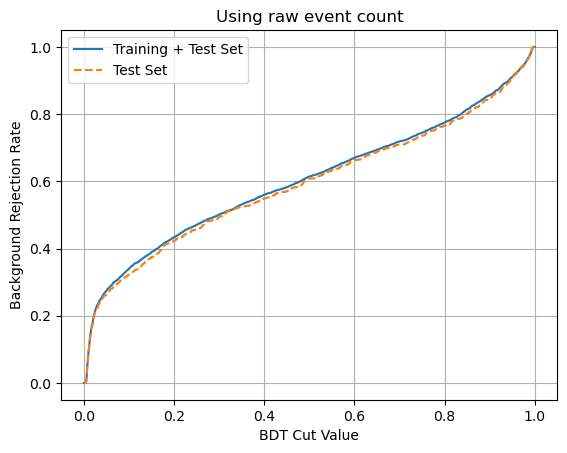

In [349]:
fig, ax = plt.subplots()

ax.plot(thres_arr[point], 1-np.array(b_FPR_raw), label='Training + Test Set')
ax.plot(thres_arr_test[point], 1-np.array(b_FPR_raw_test), label='Test Set', linestyle='dashed')

ax.set_xlabel('BDT Cut Value')
ax.set_ylabel('Background Rejection Rate')

plt.legend()
plt.grid()

plt.title("Using raw event count")

Text(0.5, 1.0, 'Using xsec-weighted event count')

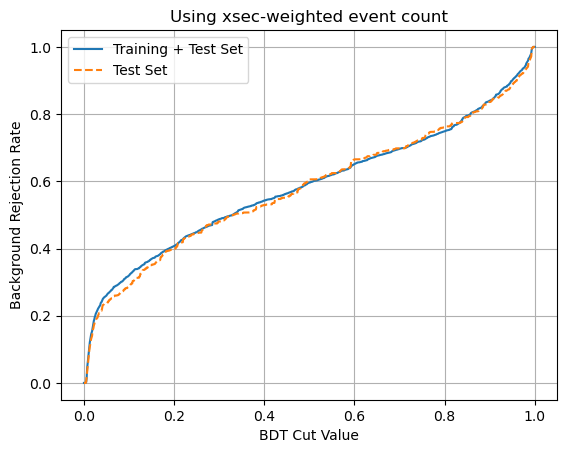

In [350]:
fig, ax = plt.subplots()

ax.plot(thres_arr[point], 1-np.array(b_FPR_weighted), label='Training + Test Set')
ax.plot(thres_arr_test[point], 1-np.array(b_FPR_weighted_test), label='Test Set', linestyle='dashed')

ax.set_xlabel('BDT Cut Value')
ax.set_ylabel('Background Rejection Rate')

plt.legend()
plt.grid()

plt.title("Using xsec-weighted event count")

Text(0.5, 1.0, 'Background')

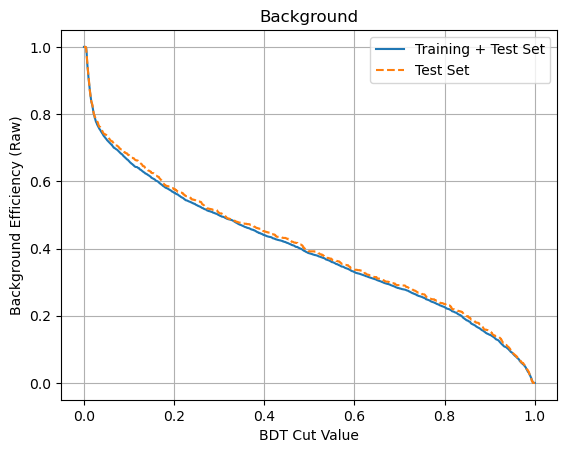

In [351]:
fig, ax = plt.subplots()

ax.plot(thres_arr[point], np.array(b_FPR_raw), label='Training + Test Set')
ax.plot(thres_arr_test[point], np.array(b_FPR_raw_test), label='Test Set', linestyle='dashed')

ax.set_xlabel('BDT Cut Value')
ax.set_ylabel('Background Efficiency (Raw)')

plt.legend()
plt.grid()

plt.title("Background")

Text(0.5, 1.0, 'Background')

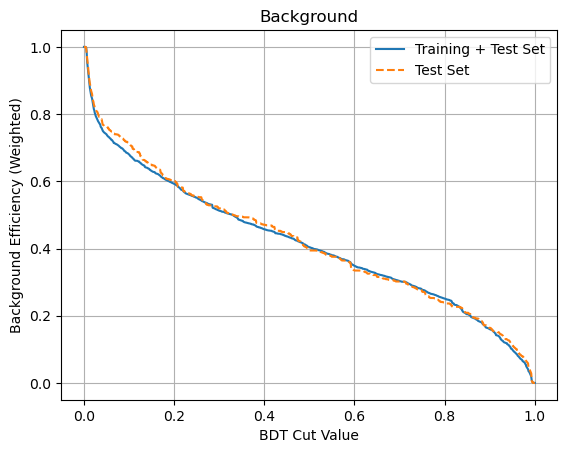

In [352]:
fig, ax = plt.subplots()

ax.plot(thres_arr[point], np.array(b_FPR_weighted), label='Training + Test Set')
ax.plot(thres_arr_test[point], np.array(b_FPR_weighted_test), label='Test Set', linestyle='dashed')

ax.set_xlabel('BDT Cut Value')
ax.set_ylabel('Background Efficiency (Weighted)')

plt.legend()
plt.grid()

plt.title("Background")

Text(0.5, 1.0, 'Background')

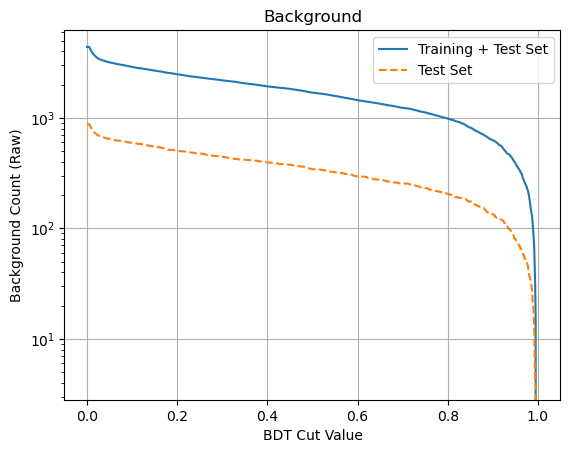

In [353]:
fig, ax = plt.subplots()

ax.plot(thres_arr[point], b_count_raw, label='Training + Test Set')
ax.plot(thres_arr_test[point], b_count_raw_test, label='Test Set', linestyle='dashed')

ax.set_xlabel('BDT Cut Value')
ax.set_ylabel('Background Count (Raw)')

plt.legend()
plt.grid()

plt.yscale('log')

plt.title("Background")

Text(0.5, 1.0, 'Background')

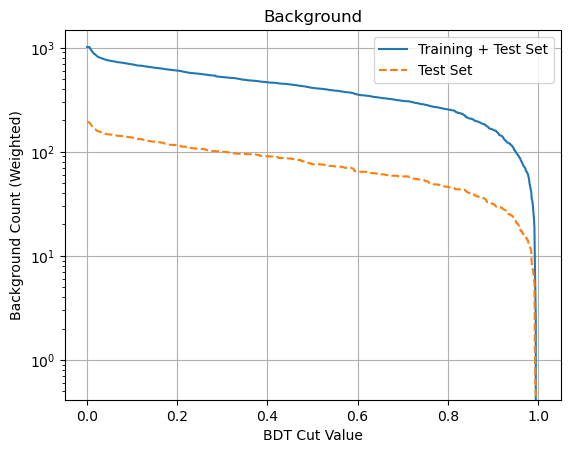

In [354]:
fig, ax = plt.subplots()

ax.plot(thres_arr[point], b_count_weighted, label='Training + Test Set')
ax.plot(thres_arr_test[point], b_count_weighted_test, label='Test Set', linestyle='dashed')

ax.set_xlabel('BDT Cut Value')
ax.set_ylabel('Background Count (Weighted)')

plt.legend()
plt.grid()

plt.yscale('log')

plt.title("Background")